# Recency, Frequency and Monetary Analysis on H&M Data

## 1 Import libraries

In [1]:
import datetime as dt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 2 Data pre-processing for RFM
- Check variables
- Derive Recency, Frequency and Monetary variables

### 2.1 Read in CSV and Conduct Basic Analysis

In [3]:
# Read in CSV
df = pd.read_csv('/Users/admin/Desktop/Y4S2/BT4211/Project/transactions_train.csv')
print('Dataframe shape:',df.shape)
print('Columns:',list(df.columns))
df.head()

Dataframe shape: (31788324, 5)
Columns: ['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id']


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


#### Check for null values

In [4]:
# Basic data check: Check for null values
for col in df.columns:
    print("Number of Null Values in", col, " : ", len(df[df[col].isna()]), "/", len(df))

Number of Null Values in t_dat  :  0 / 31788324
Number of Null Values in customer_id  :  0 / 31788324
Number of Null Values in article_id  :  0 / 31788324
Number of Null Values in price  :  0 / 31788324
Number of Null Values in sales_channel_id  :  0 / 31788324


#### Check data types

In [5]:
# Basic data check: Check data types
df.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [6]:
# Change data type
df = df.astype({'t_dat':'datetime64[ns]',
                'customer_id':'str',
                'article_id':'str',
                'price':'float',
                'sales_channel_id':'str'})
df.dtypes

t_dat               datetime64[ns]
customer_id                 object
article_id                  object
price                      float64
sales_channel_id            object
dtype: object

In [7]:
# Subset relevant columns and 
# Change order of dataframe to place customer_id at the front
cols = ['customer_id','t_dat','price','article_id','sales_channel_id']
df_new = df[cols]
df_new.head()

,customer_id,t_dat,price,article_id,sales_channel_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.050831,663713001,2
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.030492,541518023,2
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.015237,505221004,2
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.016932,685687003,2
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.016932,685687004,2


#### Check for outliers

In [8]:
def hist_boxplot(df, var_col, condition=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    if condition:
        df = df[df[var_col] < condition]
    df.hist(column=[var_col], bins=10, ax=axes[0])
    axes[0].set_title(f'Distribution of {var_col} using Histogram')
    axes[0].get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    df.boxplot(column=[var_col], return_type='axes', ax=axes[1])
    axes[1].set_title(f'Distribution of {var_col} using Boxplot')

    plt.show()

In [9]:
df_new.head()

,customer_id,t_dat,price,article_id,sales_channel_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.050831,663713001,2
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.030492,541518023,2
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.015237,505221004,2
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.016932,685687003,2
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.016932,685687004,2


Check `price`

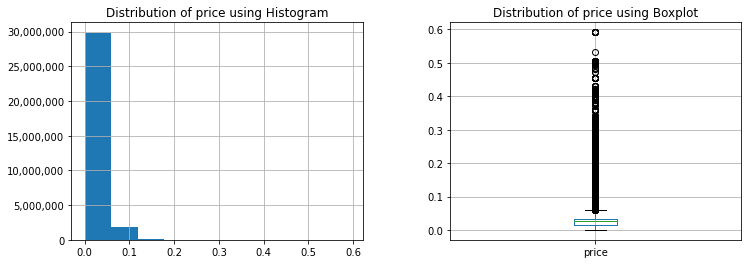

In [10]:
hist_boxplot(df_new, 'price')

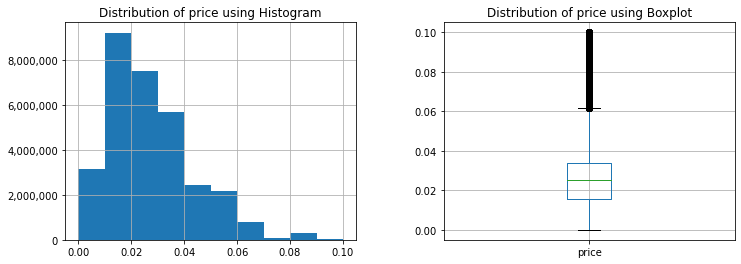

In [11]:
hist_boxplot(df_new, 'price', 0.1)

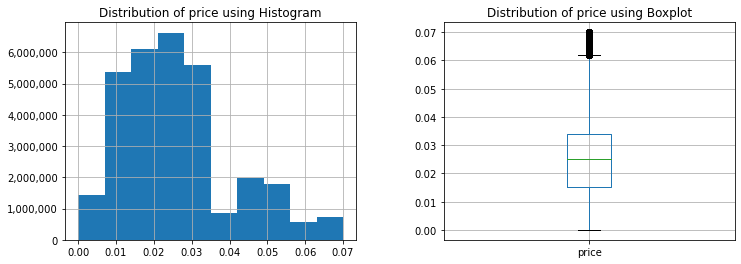

In [12]:
hist_boxplot(df_new, 'price', 0.07) # final distribution upon removal of outliers

Check number of transactions by each customer_id

In [13]:
t_by_customer = df_new.groupby('customer_id', as_index=False).size()
print(len(t_by_customer))
t_by_customer.head()

1362281


,customer_id,size
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,21
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,86
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,18
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,13


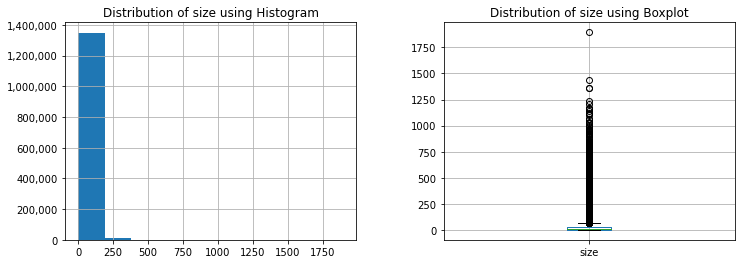

In [14]:
hist_boxplot(t_by_customer, 'size')

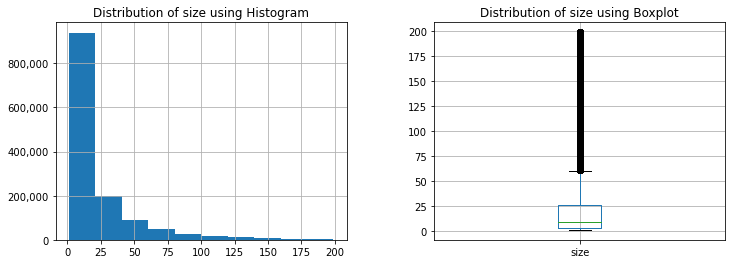

In [15]:
hist_boxplot(t_by_customer, 'size', 200)

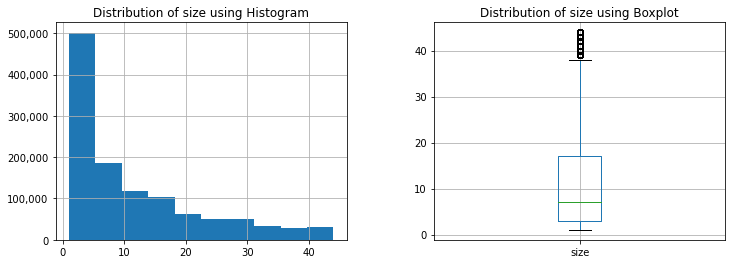

In [16]:
hist_boxplot(t_by_customer, 'size', 45) # final distribution upon removal of outliers

Check articles purchased in transactions

In [17]:
t_by_article = df_new.groupby('article_id', as_index=False).size()
print(len(t_by_article))
t_by_article.head()

104547


,article_id,size
0,108775015,10841
1,108775044,7250
2,108775051,215
3,110065001,1044
4,110065002,539


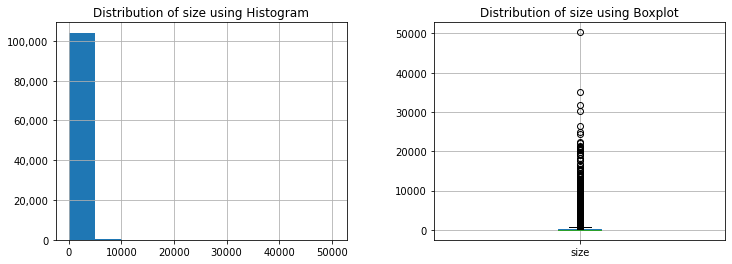

In [18]:
hist_boxplot(t_by_article, 'size')

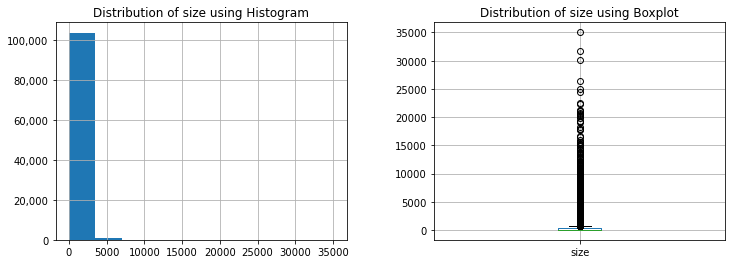

In [19]:
hist_boxplot(t_by_article, 'size', 50000)

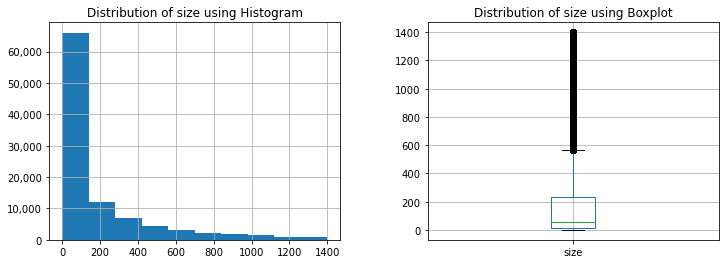

In [20]:
hist_boxplot(t_by_article, 'size', 1400)

In [21]:
# Filter out customer_ids with number of transactions too high or spend too little money
# > Filter out transactions with price <= 0.1
# > Filter out customer_ids with number of transactions <= 50

len1 = len(df_new)
print('Original length of transactions df:', len1)

df_new = df_new[df_new['price'] < 0.07]
len2 = len(df_new)
print('Length of transactions df after removing transactions with price >=0.07:', len2)

t_by_customer = df_new.groupby('customer_id', as_index=False).size()
t_by_customer = t_by_customer[t_by_customer['size'] < 45]
filtered_cust = list(t_by_customer['customer_id'].unique())
df_new = df_new[df_new['customer_id'].isin(filtered_cust)]
len3 = len(df_new)
print('Length of transactions df after removing customers >=50 trans:', len3)

t_by_article = df_new.groupby('article_id', as_index=False).size()
t_by_article = t_by_article[t_by_article['size'] < 1400]
filtered_article = list(t_by_article['article_id'].unique())
df_new = df_new[df_new['article_id'].isin(filtered_article)]
len4 = len(df_new)
print('Length of transactions df after removing articles purchased in >=1400 trans:', len4)

Original length of transactions df: 31788324
Length of transactions df after removing transactions with price >=0.07: 31028759
Length of transactions df after removing customers >=50 trans: 13001493
Length of transactions df after removing articles purchased in >=1400 trans: 10249803


In [22]:
print('Proportion of data kept: '+str((len4/len1) * 100)+'%')

Proportion of data kept: 32.24392390111539%


### 2.2 Create dataframe for RFM analysis

#### Check number of unique customers

In [23]:
# Check number of unique customers BEFORE removing outliers
len(df['customer_id'].unique())

1362281

In [24]:
# Check number of unique customers AFTER removing outliers
len(df_new['customer_id'].unique())

1108760

#### Only keep customers left from undersampling

In [25]:
sampled_cust = pd.read_csv('/Users/admin/Desktop/Y4S2/BT4211/Project/cluster_customer.csv', index_col=0)
print('Dataframe shape:',sampled_cust.shape)
print('Columns:',list(sampled_cust.columns))
sampled_cust.head()

Dataframe shape: (15538, 16)
Columns: ['customer_id', 'FN', 'age', 'price', 'club_member_status_ACTIVE', 'club_member_status_LEFT CLUB', 'club_member_status_NONE', 'club_member_status_PRE-CREATE', 'fashion_news_frequency_Monthly', 'fashion_news_frequency_None', 'fashion_news_frequency_Regularly', 'Active', 'Component 1', 'Component 2', 'Component 3', 'Cluster']


,customer_id,FN,age,price,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_NONE,club_member_status_PRE-CREATE,fashion_news_frequency_Monthly,fashion_news_frequency_None,fashion_news_frequency_Regularly,Active,Component 1,Component 2,Component 3,Cluster
0,0136f44863f72856eea74bb27047b58c7b2be8483e2e15...,0.0,54.0,2.530695,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.711247,-0.125800,1.692884,1
1,04357cc03fdb84f66d002916bbf8c509105c4e581b9888...,0.0,20.0,0.033881,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.835327,1.438856,0.007871,3
2,03270b36e1c73fcd17d46382fba42088d15bfdee8d069a...,0.0,52.0,0.050814,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.747046,-0.294206,1.383268,1
3,0575469609023a5ec20da003b63a6ac38b24e4bd770a0e...,0.0,51.0,1.144644,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.333055,-0.117880,1.439026,1
4,056b9d6f4fd23e34fcd36e388dbc6b2f3a768e4e4b51df...,0.0,48.0,0.203356,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.640567,-0.038865,1.316457,1


In [26]:
df_sample = df_new[df_new['customer_id'].isin(sampled_cust['customer_id'])]
print(df_sample.shape)
df_sample.head()

(119358, 5)


,customer_id,t_dat,price,article_id,sales_channel_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.050831,663713001,2
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.030492,541518023,2
47,001fd23db1109a94bba1319bb73df0b479059027c182da...,2018-09-20,0.016932,631744002,1
48,001fd23db1109a94bba1319bb73df0b479059027c182da...,2018-09-20,0.021593,562252035,1
49,0021da829b898f82269fc51feded4eac2129058ee95bd7...,2018-09-20,0.027441,649356002,1


#### Recency

In [29]:
# Subset dataset to get customer_id and t_dat to compute recency
df_recency = df_sample.loc[:,['customer_id','t_dat']]
print(len(df_recency) == len(df_sample)) # check
# df_recency.head()

True


In [31]:
print(df_recency['t_dat'].max())

2020-09-22 00:00:00


In [32]:
# Get last date of purchase
df_recency = pd.DataFrame(df_recency.groupby('customer_id')['t_dat'].max()).reset_index()
print(len(df_recency) == len(df_recency['customer_id'].unique()))
# df_recency.head()

True


In [33]:
# Calculate recency based on 2020-10-01
date = dt.datetime(2020, 10, 1)
df_recency['Recency'] = df_recency.t_dat.apply(lambda x:(date - x).days)
df_recency.head()

,customer_id,t_dat,Recency
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2020-09-05,26
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2020-09-15,16
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2020-08-12,50
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,2020-07-21,72
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,2018-11-03,698


#### Frequency

In [34]:
# Subset dataset to get customer_id and t_dat to compute frequency
df_frequency = df_sample.loc[:,['customer_id','t_dat']]
print(len(df_frequency) == len(df_sample)) # check
# df_frequency.head()

True


In [35]:
# Calculate frequency based on total number of purchases
df_frequency = pd.DataFrame(df_frequency.groupby('customer_id')['t_dat'].count()).reset_index()
print(len(df_frequency) == len(df_sample['customer_id'].unique()))
df_frequency.columns = ['customer_id', 'Frequency']
df_frequency.head()

True


,customer_id,Frequency
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,17
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,15
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,11
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,2
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,15


(array([5817., 2077., 1291., 1143.,  662.,  513.,  507.,  259.,  149.,
          36.]),
 array([ 1. ,  5.3,  9.6, 13.9, 18.2, 22.5, 26.8, 31.1, 35.4, 39.7, 44. ]),
 <a list of 10 Patch objects>)

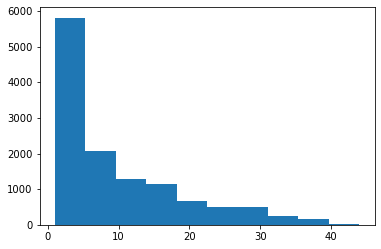

In [36]:
plt.hist(df_frequency['Frequency'])

#### Monetary

In [37]:
# Subset dataset to get customer_id and price to compute monetary
df_monetary = df_sample.loc[:,['customer_id','price']]
print(len(df_monetary) == len(df_sample)) # check
# df_monetary.head()

True


In [38]:
# Calculate monetary based on average amount spent per transaction
df_monetary = pd.DataFrame(df_monetary.groupby('customer_id')['price'].mean()).reset_index()
print(len(df_monetary) == len(df_sample['customer_id'].unique()))
df_monetary.columns = ['customer_id', 'Monetary']
df_monetary.head()

True


,customer_id,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.030104
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.042356
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0.037310
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,0.033881
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,0.014833


In [39]:
# Multiply by 1000
df_monetary['Monetary'] = df_monetary['Monetary']*1000
df_monetary.head()

,customer_id,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,30.103689
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,42.355932
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,37.309707
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,33.881356
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,14.832768


(array([ 127.,  949., 2701., 3681., 2731., 1102.,  624.,  324.,  117.,
          98.]),
 array([ 1.50847458,  8.22033898, 14.93220339, 21.6440678 , 28.3559322 ,
        35.06779661, 41.77966102, 48.49152542, 55.20338983, 61.91525424,
        68.62711864]),
 <a list of 10 Patch objects>)

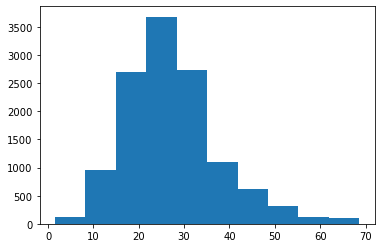

In [40]:
plt.hist(df_monetary['Monetary'])

## 3 RFM analysis
https://github.com/klaudia-nazarko/rfm-analysis-python/blob/master/rfm_analysis_python.ipynb

### 3.1 Combine RFM into a single dataframe
- `Recency`: Number of days from latest transaction date to 2020-10-1 (because the latest t_dat in dataset is 2020-9-22 so chose 2020-10-1 as a reasonable benchmark)
- `Frequency`: Number of transactions per customer_id
- `Money`: Average spending per transaction

In [41]:
df_rfm = pd.merge(df_recency, df_frequency, on='customer_id')
df_rfm = pd.merge(df_rfm, df_monetary, on='customer_id')
df_rfm = df_rfm.drop(['t_dat'], axis=1)
print('Dataframe shape:',df_rfm.shape)
df_rfm.head()

Dataframe shape: (12454, 4)


,customer_id,Recency,Frequency,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,17,30.103689
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,15,42.355932
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,11,37.309707
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,72,2,33.881356
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,698,15,14.832768


#### Normalize by scaling

In [42]:
# StandardScaler
from sklearn.preprocessing import StandardScaler

rfm = df_rfm.drop(['customer_id'], axis=1)

scaler = StandardScaler()
scaler.fit(rfm)
customers_normalized = scaler.transform(rfm)

rfm = pd.DataFrame(customers_normalized, columns=['Recency_norm','Frequency_norm','Monetary_norm'])
rfm.head()

# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[0. 0. 0.]
[1. 1. 1.]


In [43]:
rfm.insert(0, "customer_id", df_rfm.customer_id)
rfm.head()

,customer_id,Recency_norm,Frequency_norm,Monetary_norm
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,-1.089981,0.812339,0.266630
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-1.134680,0.593265,1.440376
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-0.982703,0.155115,0.956956
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,-0.884366,-0.830722,0.628525
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,1.913785,0.593265,-1.196300


In [44]:
df_rfm['Recency_norm'] = rfm['Recency_norm']
df_rfm['Frequency_norm'] = rfm['Frequency_norm']
df_rfm['Monetary_norm'] = rfm['Monetary_norm']
df_rfm.head()

,customer_id,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,17,30.103689,-1.089981,0.812339,0.266630
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,15,42.355932,-1.134680,0.593265,1.440376
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,11,37.309707,-0.982703,0.155115,0.956956
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,72,2,33.881356,-0.884366,-0.830722,0.628525
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,698,15,14.832768,1.913785,0.593265,-1.196300


In [45]:
# Check
print(min(df_rfm['Recency_norm']), max(df_rfm['Recency_norm']))
print(min(df_rfm['Frequency_norm']), max(df_rfm['Frequency_norm']))
print(min(df_rfm['Monetary_norm']), max(df_rfm['Monetary_norm']))

-1.1659687611713772 2.110459803300615
-0.940259177336392 3.769849660177072
-2.472746547053553 3.9571151247754677


(array([5817., 2077., 1291., 1143.,  662.,  513.,  507.,  259.,  149.,
          36.]),
 array([-9.40259177e-01, -4.69248294e-01,  1.76259017e-03,  4.72773474e-01,
         9.43784358e-01,  1.41479524e+00,  1.88580613e+00,  2.35681701e+00,
         2.82782789e+00,  3.29883878e+00,  3.76984966e+00]),
 <a list of 10 Patch objects>)

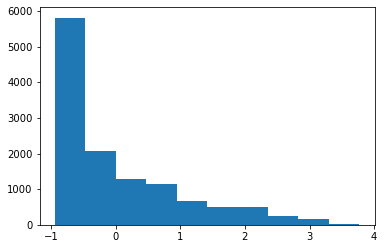

In [46]:
plt.hist(df_rfm['Frequency_norm'])

(array([ 127.,  949., 2701., 3681., 2731., 1102.,  624.,  324.,  117.,
          98.]),
 array([-2.47274655, -1.82976038, -1.18677421, -0.54378805,  0.09919812,
         0.74218429,  1.38517046,  2.02815662,  2.67114279,  3.31412896,
         3.95711512]),
 <a list of 10 Patch objects>)

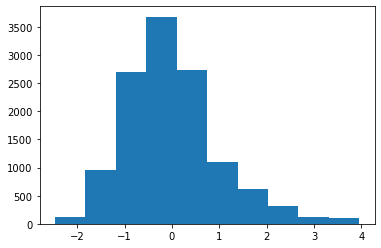

In [47]:
plt.hist(df_rfm['Monetary_norm'])

### 3.2a Conduct KMeans Analysis by grouping customers into segments


In [48]:
rfm.head()

,customer_id,Recency_norm,Frequency_norm,Monetary_norm
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,-1.089981,0.812339,0.266630
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-1.134680,0.593265,1.440376
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-0.982703,0.155115,0.956956
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,-0.884366,-0.830722,0.628525
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,1.913785,0.593265,-1.196300


In [49]:
from sklearn.cluster import KMeans
rfm_normalised = rfm.loc[:,['Recency_norm','Frequency_norm', 'Monetary_norm']]

KMeans(max_iter=50, n_clusters=4)

#### Elbow Method
4 Clusters

In [54]:
ssd = []
range_n_clusters = [2,3,4,5,6,7,8]
for cluster in range_n_clusters:
    kmeans = KMeans(n_clusters=cluster, max_iter=50)
    kmeans.fit(rfm_normalised)
    
    ssd.append(kmeans.inertia_)

Text(0, 0.5, 'ssd')

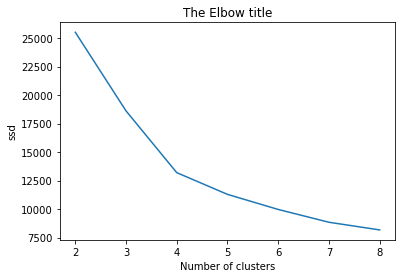

In [56]:
number_clusters = range(2,9)
plt.plot(number_clusters,ssd)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('ssd')

#### Silhouette Analysis
4 Clusters

In [61]:
from sklearn.metrics import silhouette_score
for cluster in range_n_clusters:
    kmeans = KMeans(n_clusters=cluster, max_iter=50)
    kmeans.fit(rfm_normalised)
    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(rfm_normalised, cluster_labels)
    print("n_clusters={0}, silhouette score is {1}".format(cluster, silhouette_avg))

n_clusters=2, silhouette score is 0.3154040606694666
n_clusters=3, silhouette score is 0.3264471260937712
n_clusters=4, silhouette score is 0.3508939114075935
n_clusters=5, silhouette score is 0.3306441002777714
n_clusters=6, silhouette score is 0.3073944685717529
n_clusters=7, silhouette score is 0.2912127919610948
n_clusters=8, silhouette score is 0.2886682316611026


#### Finalised to be 4 clusters

In [63]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_normalised)

KMeans(max_iter=50, n_clusters=4)

In [67]:
rfm_normalised.loc[:,'customer_id'] = rfm['customer_id']

In [69]:
rfm_normalised['cluster'] = kmeans.labels_
rfm_normalised.head()

,Recency_norm,Frequency_norm,Monetary_norm,customer_id,cluster
0,-1.089981,0.812339,0.266630,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2
1,-1.134680,0.593265,1.440376,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0
2,-0.982703,0.155115,0.956956,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,3
3,-0.884366,-0.830722,0.628525,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,3
4,1.913785,0.593265,-1.196300,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,1


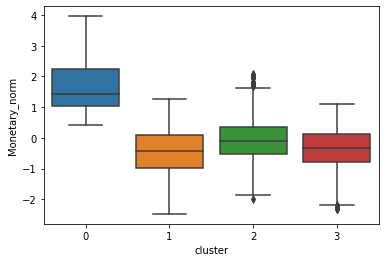

In [72]:
sns.boxplot(x = 'cluster', y='Monetary_norm', data=rfm_normalised)

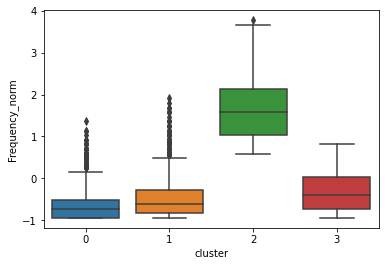

In [73]:
sns.boxplot(x = 'cluster', y='Frequency_norm', data=rfm_normalised)

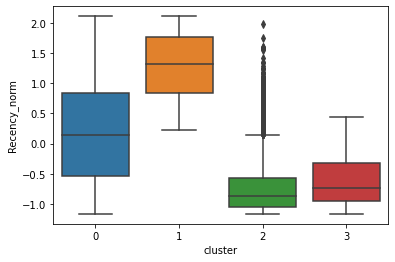

In [74]:
sns.boxplot(x = 'cluster', y='Recency_norm', data=rfm_normalised)

In [75]:
rfm_normalised['cluster'].unique()

array([2, 0, 3, 1], dtype=int32)

#### Export clusters

In [76]:
df_clusters = rfm_normalised.loc[:,['customer_id','cluster']]
df_clusters.head()

,customer_id,cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,3
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,3
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,1


In [77]:
df_clusters.to_csv('clusters_kmeans.csv', index=False)

## 3.3 RFM Segment Analysis

### 3.3.1 General Analysis on RFM Segments

#### Number of customers in each RFM Segment defined

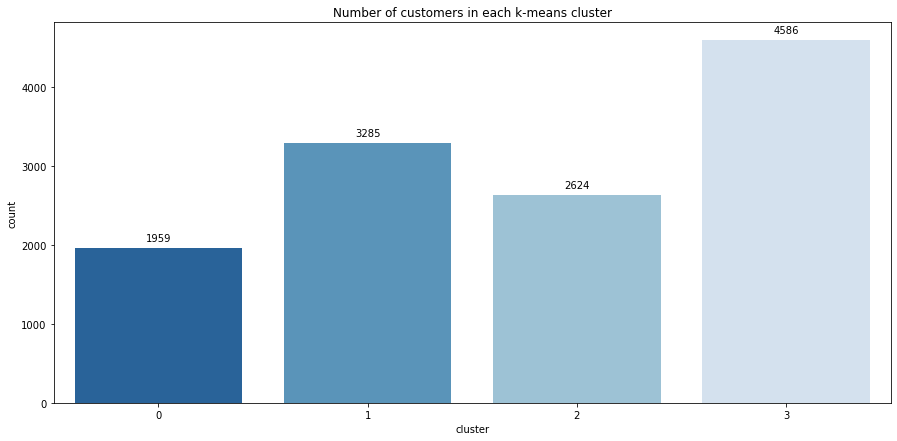

In [80]:
palette = sns.color_palette("Blues_r", n_colors=4)

fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x='cluster', data=rfm_normalised, palette=palette)
for p in ax.patches:
    ax.annotate(p.get_height(), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
ax.set_title('Number of customers in each k-means cluster')
plt.show()

#### Proportion of customers in each RFM Segment & Proportion of monetary amount by customers in each RFM Segment

In [91]:
df_analysis

,label,count,Recency_norm,Frequency_norm,Monetary_norm,count_share,Monetary_share
0,2,2624,-0.690215,1.645684,-0.000030,0.210695,-0.098608
1,3,4586,-0.613950,-0.312748,-0.000076,0.368235,-0.443125
2,0,1959,0.202020,-0.608683,0.000841,0.157299,2.091760
3,1,3285,1.287958,-0.514947,-0.000132,0.263771,-0.550028


In [100]:
for col in ['count']:
    print(df_analysis['label'])

0    2
1    3
2    0
3    1
Name: label, dtype: object


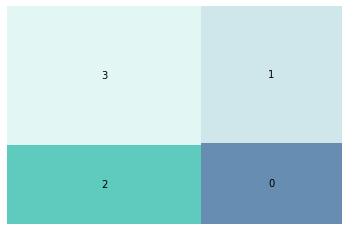

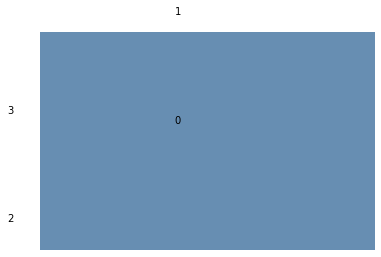

In [107]:
import squarify
agg_dict2 = {
    'customer_id': 'count',
    'Recency_norm': 'mean',
    'Frequency_norm': 'mean',
    'Monetary_norm': 'mean'
}

df_analysis = rfm_normalised.groupby('cluster').agg(agg_dict2).sort_values(by='Recency_norm').reset_index()
df_analysis['cluster'] = df_analysis['cluster'].astype(str)
df_analysis.rename({'cluster': 'label', 'customer_id': 'count'}, axis=1, inplace=True)
df_analysis['count_share'] = df_analysis['count'] / df_analysis['count'].sum()
df_analysis['Monetary_share'] = df_analysis['Monetary_norm'] / df_analysis['Monetary_norm'].sum()
df_analysis['Monetary_norm'] = df_analysis['Monetary_norm'] / df_analysis['count']

colors = ['#37BEB0', '#DBF5F0', '#41729F', '#C3E0E5']

for col in ['count', 'Monetary_norm']:
    labels = df_analysis['label']
    # fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=df_analysis[col], label=labels, alpha=.8, color=colors)
    ax.set_title('RFM Segments of Customers (%s)' % col)
    plt.axis('off')
    plt.show()

#### View Recency vs Frequency for each RFM Segment for comparison

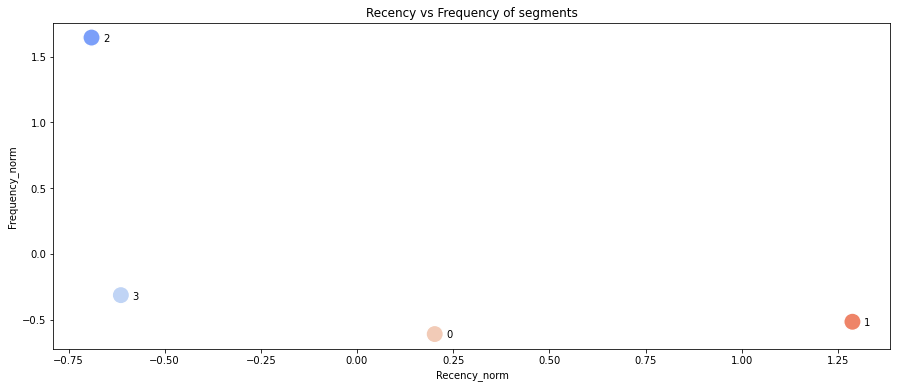

In [108]:
palette = sns.color_palette("coolwarm", 4)

fig, ax = plt.subplots(figsize=(15,6))
plot = sns.scatterplot(x='Recency_norm', y='Frequency_norm', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['Recency_norm'][i]+0.03, #+0.008,
               df_analysis['Frequency_norm'][i]-0.03, #-0.002,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Recency vs Frequency of segments')
ax.get_legend().remove()
# plt.legend(loc='upper left')
plt.show()

#### View Recency vs Monetary of each RFM Segment for comparison

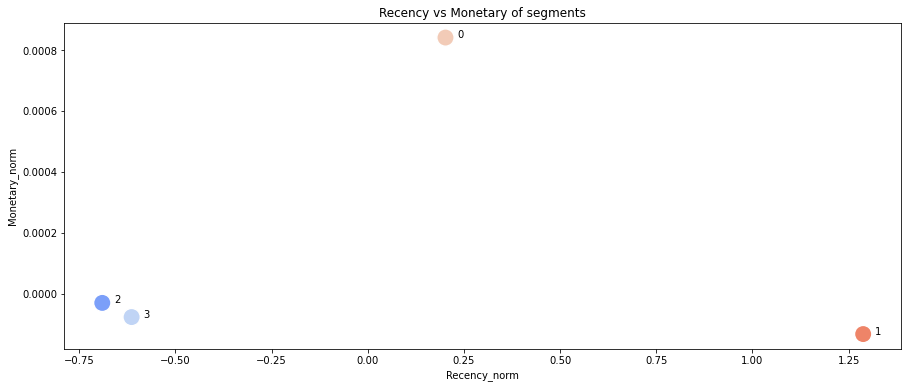

In [130]:
palette = sns.color_palette("coolwarm", 4)

fig, ax = plt.subplots(figsize=(15,6))
plot = sns.scatterplot(x='Recency_norm', y='Monetary_norm', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['Recency_norm'][i]+0.03,
               df_analysis['Monetary_norm'][i], #-0.002,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Recency vs Monetary of segments')
ax.get_legend().remove()
# plt.legend(loc='upper left')
plt.show()

#### View Frequency vs Monetary of each RFM Segment for comparison

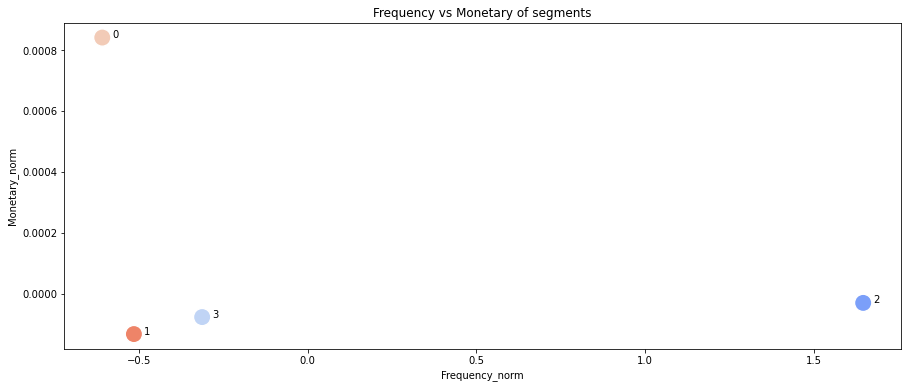

In [132]:
palette = sns.color_palette("coolwarm", 4)

fig, ax = plt.subplots(figsize=(15,6))
plot = sns.scatterplot(x='Frequency_norm', y='Monetary_norm', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['Frequency_norm'][i]+0.03,
               df_analysis['Monetary_norm'][i], #-0.003,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Frequency vs Monetary of segments')
ax.get_legend().remove()
# plt.legend(loc='upper left')
plt.show()

#### Visualize all elements together - Snakeplot

In [133]:
df_snake = rfm_normalised.loc[:,['customer_id','Recency_norm','Frequency_norm','Monetary_norm','cluster']]
df_snake.rename({'Recency_norm':'recency',
                 'Frequency_norm':'frequency',
                 'Monetary_norm':'monetary'}, axis=1, inplace=True)
df_snake.head()
df_melt = pd.melt(df_snake.reset_index(), 
                  id_vars=['customer_id','cluster'],
                  value_vars=['recency','frequency','monetary'],
                  var_name='Attribute',
                  value_name='Value')
df_melt.head()

,customer_id,cluster,Attribute,Value
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2,recency,-1.089981
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,recency,-1.134680
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,3,recency,-0.982703
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,3,recency,-0.884366
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,1,recency,1.913785


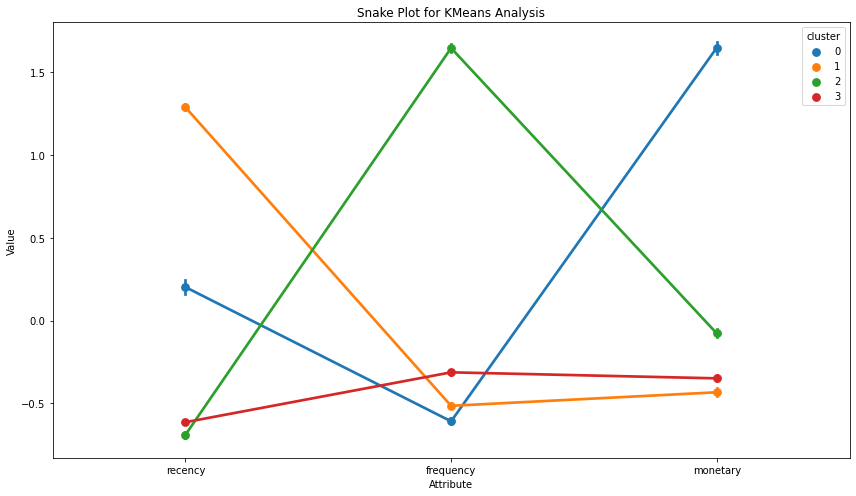

In [135]:
plt.figure(figsize=(12, 7))
plt.title('Snake Plot for KMeans Analysis')
plt.xlabel('Attribute')
plt.ylabel('Value')
sns.pointplot(data=df_melt, x='Attribute', y='Value', hue='cluster')

plt.tight_layout()

### 3.3.2 Demographic Analysis of RFM Segments

#### Read in CSV and Conduct Basic Analysis

In [136]:
customers = pd.read_csv('/Users/admin/Desktop/Y4S2/BT4211/Project/customers.csv')
print('Dataframe shape:',customers.shape)
customers.head()

Dataframe shape: (1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [137]:
customers = customers[customers['customer_id'].isin(sampled_cust['customer_id'])]
print(customers.shape)
customers.head()

(15538, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
10,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,NaN,NaN,ACTIVE,NONE,29.0,d93e1aaecdebf9f71ab42cc0c5fdbb378514c94971ad1c...


In [138]:
customers = customers.loc[:,['customer_id','Active','club_member_status','fashion_news_frequency','age','postal_code']]
print('Dataframe shape:',customers.shape)
customers.head()

Dataframe shape: (15538, 6)


,customer_id,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
10,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,NaN,ACTIVE,NONE,29.0,d93e1aaecdebf9f71ab42cc0c5fdbb378514c94971ad1c...


In [139]:
# Basic data check: Check for null values
for col in customers.columns:
    print("Number of Null Values in", col, " : ", len(customers[customers[col].isna()]), "/", len(customers))

Number of Null Values in customer_id  :  0 / 15538
Number of Null Values in Active  :  7769 / 15538
Number of Null Values in club_member_status  :  31 / 15538
Number of Null Values in fashion_news_frequency  :  129 / 15538
Number of Null Values in age  :  0 / 15538
Number of Null Values in postal_code  :  0 / 15538


In [140]:
# Handle null values
customers['Active'] = customers['Active'].fillna(0)
customers['club_member_status'] = customers['club_member_status'].fillna('NONE')
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].fillna('None')
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace(['NONE'],'None')
customers = customers.dropna(subset=['age'])

# Check for null values
for col in customers.columns:
    print("Number of Null Values in", col, " : ", len(customers[customers[col].isna()]), "/", len(customers))
    
customers.dtypes

Number of Null Values in customer_id  :  0 / 15538
Number of Null Values in Active  :  0 / 15538
Number of Null Values in club_member_status  :  0 / 15538
Number of Null Values in fashion_news_frequency  :  0 / 15538
Number of Null Values in age  :  0 / 15538
Number of Null Values in postal_code  :  0 / 15538


customer_id                object
Active                    float64
club_member_status         object
fashion_news_frequency     object
age                       float64
postal_code                object
dtype: object

In [141]:
# Convert datatypes to suitable datatypes
customers = customers.astype({'customer_id':'str',
                              'Active':'category',
                              'club_member_status':'category',
                              'fashion_news_frequency':'category',
                              'age':'int64',
                              'postal_code':'category'})
customers.dtypes

customer_id                 object
Active                    category
club_member_status        category
fashion_news_frequency    category
age                          int64
postal_code               category
dtype: object

In [145]:
rfm_customers = customers.merge(rfm_normalised[['customer_id', 'Recency_norm',
                                                'Frequency_norm','Monetary_norm','cluster']], on='customer_id')
print('Dataframe shape:',rfm_customers.shape)
rfm_customers.head()

Dataframe shape: (12454, 10)


,customer_id,Active,club_member_status,fashion_news_frequency,age,postal_code,Recency_norm,Frequency_norm,Monetary_norm,cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,ACTIVE,None,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,-1.089981,0.812339,0.266630,2
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,ACTIVE,None,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,-1.134680,0.593265,1.440376,0
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,ACTIVE,Regularly,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,-0.982703,0.155115,0.956956,3
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,0.0,ACTIVE,None,29,d93e1aaecdebf9f71ab42cc0c5fdbb378514c94971ad1c...,-0.884366,-0.830722,0.628525,3
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,0.0,ACTIVE,None,31,2c29ae653a9282cce4151bd87643c907644e09541abc28...,1.913785,0.593265,-1.196300,1


#### Demographic Analysis 1: Descriptive analysis

#### - Demographic Analysis 1.1: Descriptive analysis by Recency, Frequency and Monetary

In [146]:
rfm_customers.groupby('cluster')['Recency_norm','Frequency_norm', 'Monetary_norm'].describe()

Recency_norm                                                    \
               count      mean       std       min       25%       50%   
cluster                                                                  
0             1959.0  0.202020  0.901838 -1.165969 -0.531245  0.143709   
1             3285.0  1.287958  0.516782  0.219697  0.841011  1.319289   
2             2624.0 -0.690215  0.512459 -1.165969 -1.049752 -0.862016   
3             4586.0 -0.613950  0.414499 -1.165969 -0.951414 -0.732390   

                            Frequency_norm                                \
              75%       max          count      mean       std       min   
cluster                                                                    
0        0.841011  2.110460         1959.0 -0.608683  0.404233 -0.940259   
1        1.761808  2.110460         3285.0 -0.514947  0.453281 -0.940259   
2       -0.571474  1.976363         2624.0  1.645684  0.703350  0.593265   
3       -0.325630  0.443191         4586.0 -0.312748  0.469285 -0.940259   

                                                Monetary_norm            \
              25%       50%       75%       max         count      mean   
cluster                                                                   
0       -0.940259 -0.721184 -0.502110  1.360027        1959.0  1.647489   
1       -0.830722 -0.611647 -0.283035  1.907714        3285.0 -0.433207   
2        1.031414  1.579101  2.126788  3.769850        2624.0 -0.077664   
3       -0.721184 -0.392572  0.045578  0.812339        4586.0 -0.349009   

                                                                     
              std       min       25%       50%       75%       max  
cluster                                                              
0        0.818783  0.425562  1.034451  1.440376  2.252228  3.957115  
1        0.714128 -2.472747 -0.995177 -0.426881  0.093515  1.278006  
2        0.642254 -1.986538 -0.525633 -0.107100  0.358373  2.070373  
3        0.639746 -2.326613 -0.792215 -0.332957  0.133539  1.115636

#### - Demographic Analysis 1.2: Descriptive analysis by customers demographics

In [147]:
rfm_customers.groupby('cluster')['Active','club_member_status','fashion_news_frequency','age','postal_code'].describe()

age                                                    
          count       mean        std   min   25%   50%   75%   max
cluster                                                            
0        1959.0  39.534967  15.502106  17.0  26.0  37.0  52.0  85.0
1        3285.0  38.060883  14.283303  16.0  25.0  36.0  50.0  89.0
2        2624.0  35.990473  13.923334  17.0  24.0  31.0  49.0  90.0
3        4586.0  34.646751  14.740442  17.0  22.0  29.0  48.0  90.0

#### Demographic Analysis 2: Graphic analysis for the different RFM segments (Bottom 2 analyses are the same just displayed in different sequences)

In [148]:
def countplot(df, var_col, xticklabels, rotate=False):
    plt.figure(figsize=(12,5))
    ax = sns.countplot(x=var_col, data=df)
    ax.set(xlabel=var_col, ylabel='Count')
    for p in ax.patches:
        ax.annotate(p.get_height(), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')

#     ax.set_xticklabels(xticklabels)
    if rotate:
        plt.xticks(rotation=45)

    max_height = max([x.get_height() for x in ax.patches])
    # plt.ylim(0, max_height*1.25)
    plt.title(f'Distribution of {var_col}')
    plt.show()

#### - Demographic Analysis 2.1: View graphs by RFM Segments (Compare within RFM Segments)

In [72]:
# labels = list(rfm_customers['rfm_label'].unique())
# for label in labels:
#     print('----- RFM Segment:',label,'-----')
#     subset_df = rfm_customers[rfm_customers['rfm_label']==label]
#     for col in ['Active','club_member_status','fashion_news_frequency','age']:
#         print('Plotting countplot...')
#         print('RFM Segment:',label)
#         print('Variable:',col)
#         if col=='age':
#             sorted_x = list(subset_df[col].unique())
#             sorted_x.sort()
#             countplot(subset_df, col, sorted_x, rotate=True)
#         else:
#             countplot(subset_df, col, list(subset_df[col].unique()))

#### - Demographic Analysis 2.2: View graphs by Variables (Compare across RFM Segments)

Demographic Analysis 2.2.1: Using bar charts

----- Variable: Active -----
Plotting countplot...
Variable: Active
RFM Segment: 2


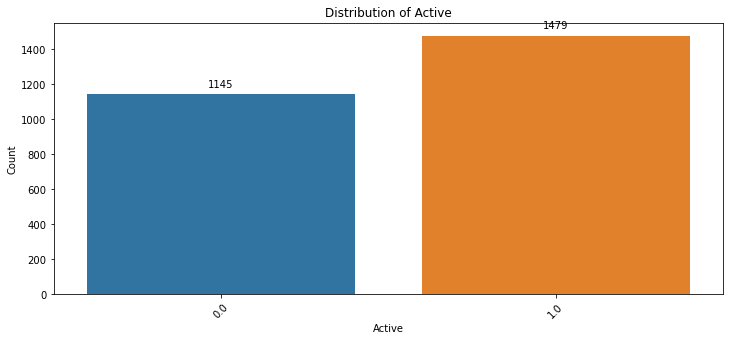

Plotting countplot...
Variable: Active
RFM Segment: 0


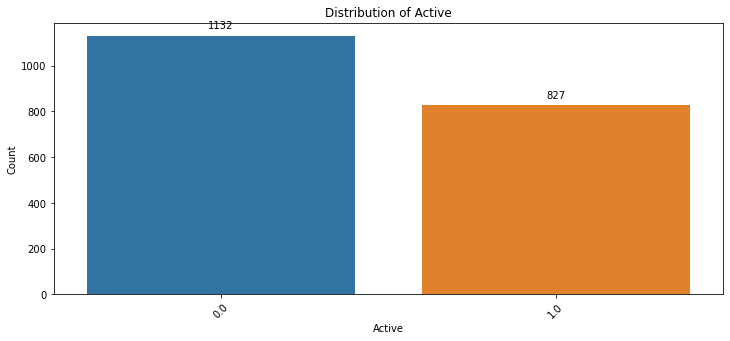

Plotting countplot...
Variable: Active
RFM Segment: 3


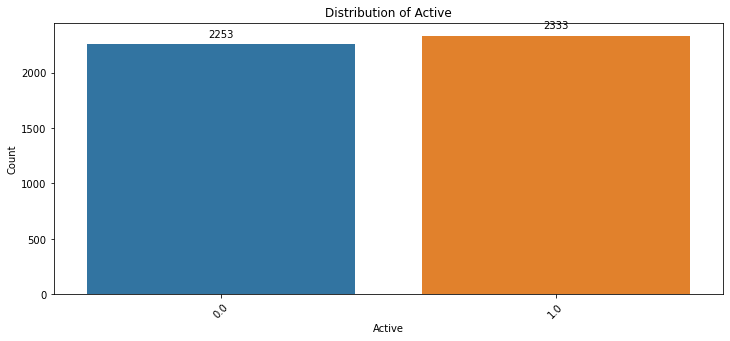

Plotting countplot...
Variable: Active
RFM Segment: 1


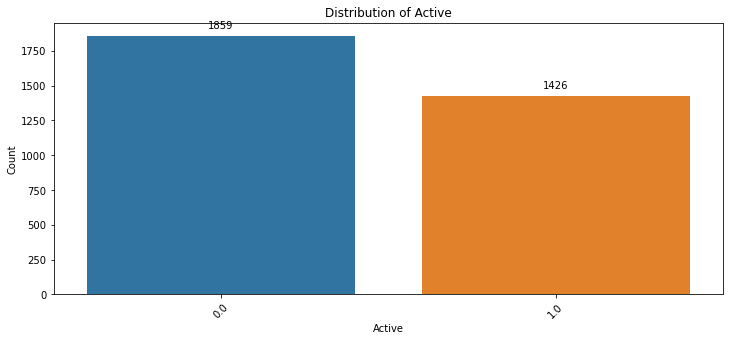

----- Variable: club_member_status -----
Plotting countplot...
Variable: club_member_status
RFM Segment: 2


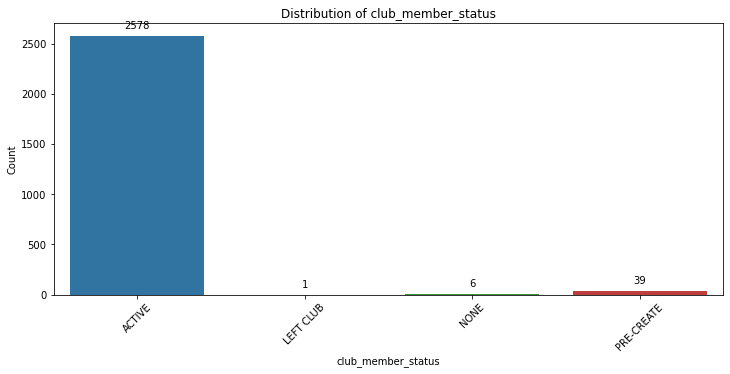

Plotting countplot...
Variable: club_member_status
RFM Segment: 0


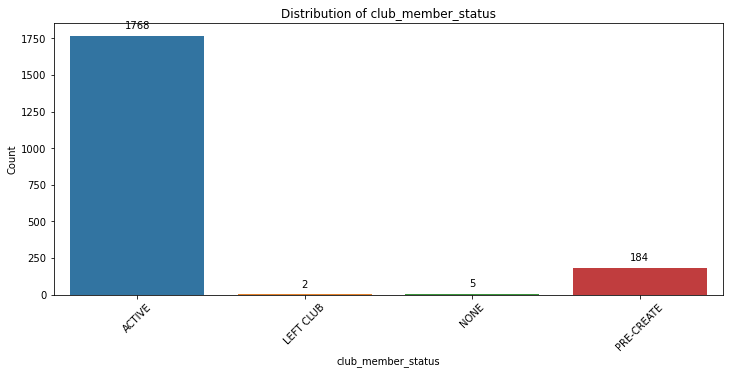

Plotting countplot...
Variable: club_member_status
RFM Segment: 3


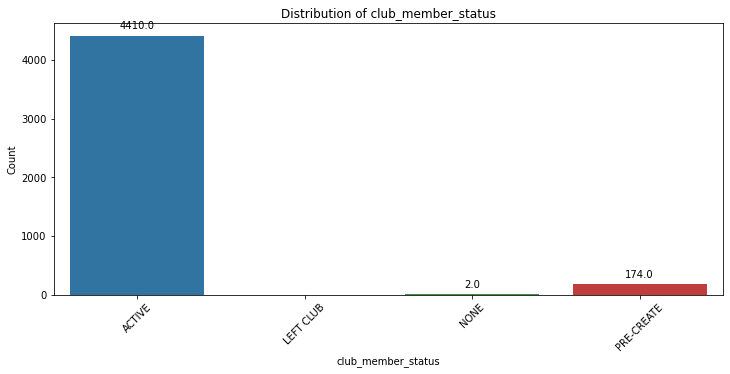

Plotting countplot...
Variable: club_member_status
RFM Segment: 1


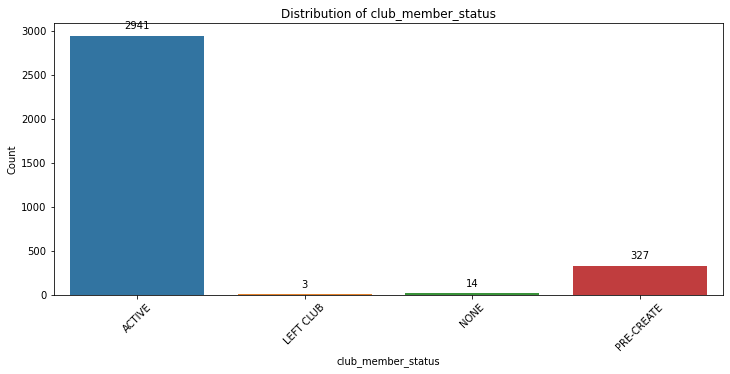

----- Variable: fashion_news_frequency -----
Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: 2


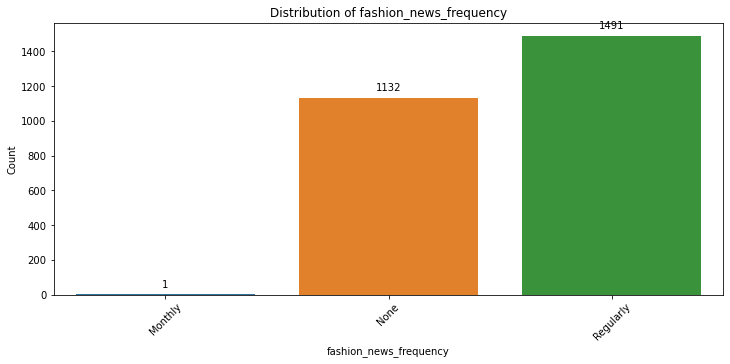

Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: 0


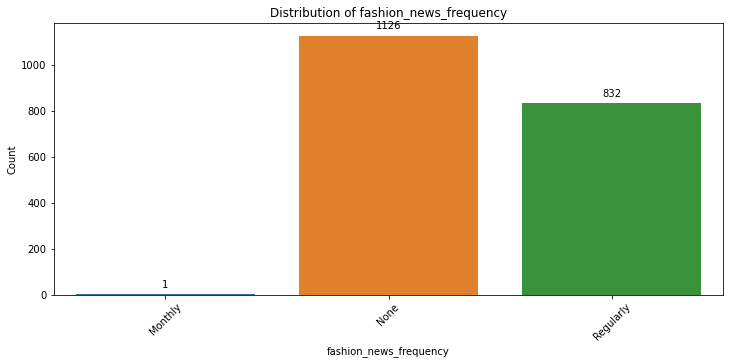

Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: 3


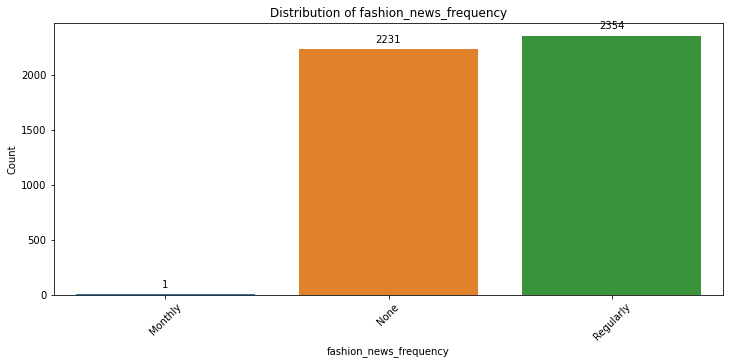

Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: 1


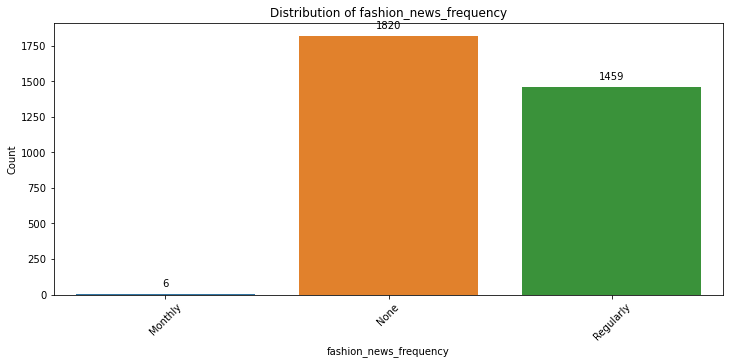

----- Variable: age -----
Plotting countplot...
Variable: age
RFM Segment: 2


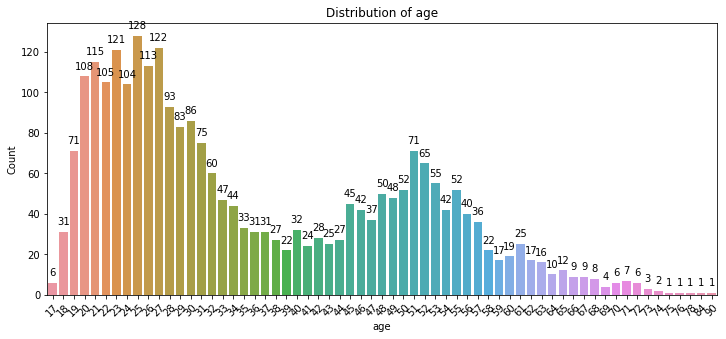

Plotting countplot...
Variable: age
RFM Segment: 0


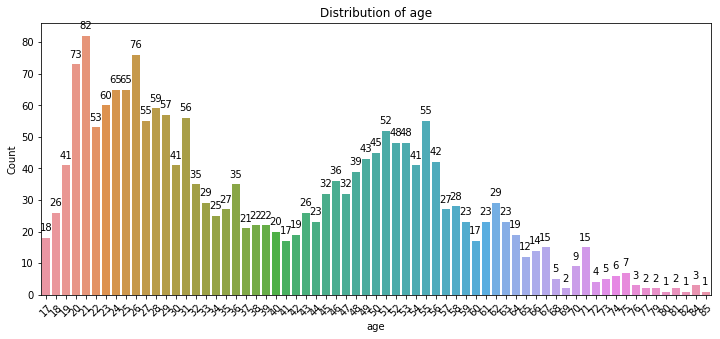

Plotting countplot...
Variable: age
RFM Segment: 3


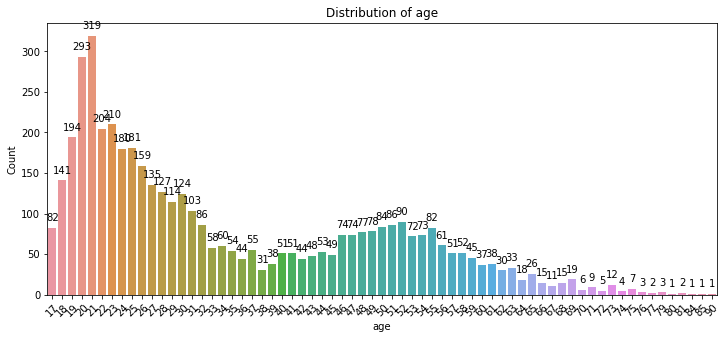

Plotting countplot...
Variable: age
RFM Segment: 1


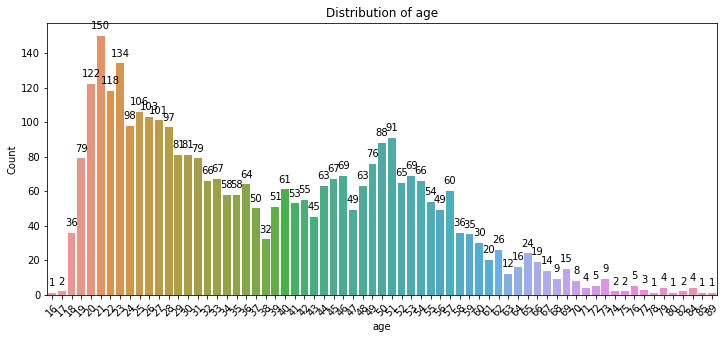

In [149]:
labels = list(rfm_customers['cluster'].unique())
for col in ['Active','club_member_status','fashion_news_frequency','age']:
    print('----- Variable:',col,'-----')
    for label in labels:
        subset_df = rfm_customers[rfm_customers['cluster']==label]
        print('Plotting countplot...')
        print('Variable:',col)
        print('RFM Segment:',label)
        sorted_x = list(subset_df[col].unique())
#         sorted_x.sort()
        countplot(subset_df, col, sorted_x, rotate=True)

Demographic Analysis 2.2.2: Using pie charts (to better see the proportion) *excluded age variable here

----- Variable: Active -----


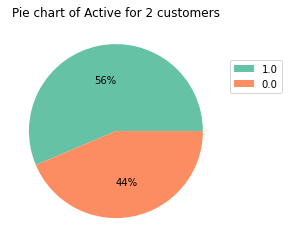

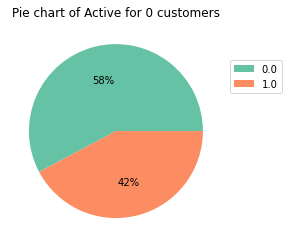

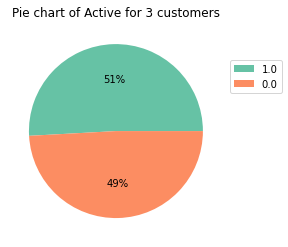

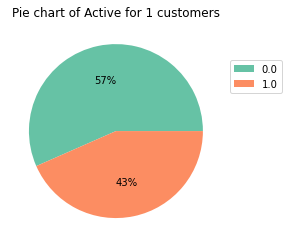

----- Variable: club_member_status -----


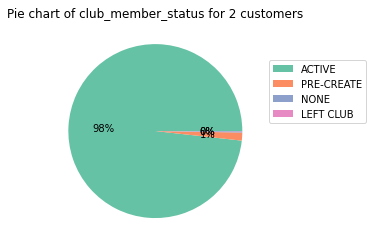

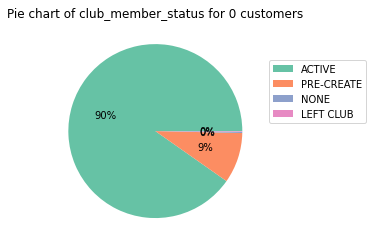

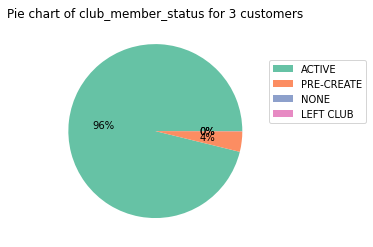

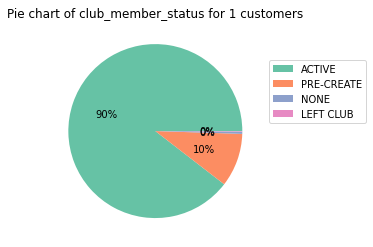

----- Variable: fashion_news_frequency -----


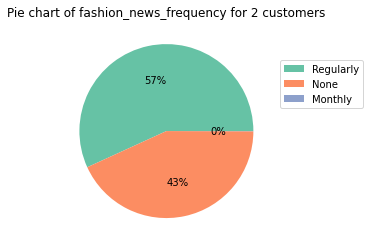

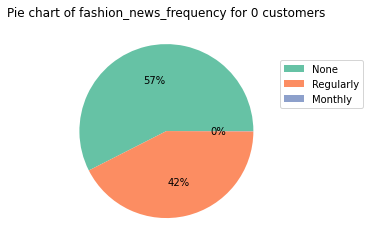

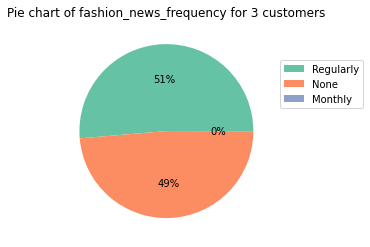

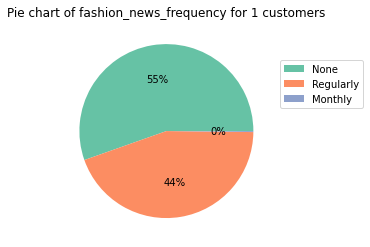

In [150]:
labels = list(rfm_customers['cluster'].unique())
for col in ['Active','club_member_status','fashion_news_frequency']:
    print('----- Variable:',col,'-----')
    for label in labels:
        subset_df = rfm_customers[rfm_customers['cluster']==label]
        colors = sns.color_palette('Set2')
        plt.pie(subset_df[col].value_counts(), colors=colors, autopct='%.0f%%')
        plt.title(f'Pie chart of {col} for {label} customers' )
        plt.legend(subset_df[col].value_counts().index, bbox_to_anchor = (1, 0.85))
        plt.show()

### 3.3.3 Comparing Demographics Across Variables

In [151]:
# Find number of unique values in each column
for col in customers.columns[1:]:
    print('Number of unique values in ' + col + ': ' + str(len(customers[col].unique())) + ' / ' + str(len(customers)))

Number of unique values in Active: 2 / 15538
Number of unique values in club_member_status: 4 / 15538
Number of unique values in fashion_news_frequency: 3 / 15538
Number of unique values in age: 71 / 15538
Number of unique values in postal_code: 13798 / 15538


#### Age vs Columns

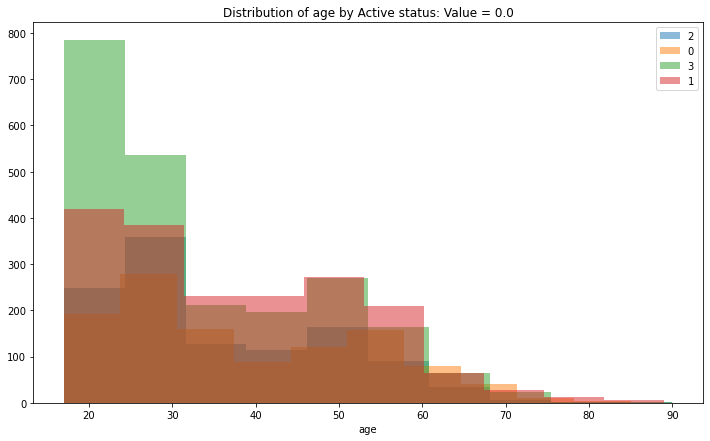

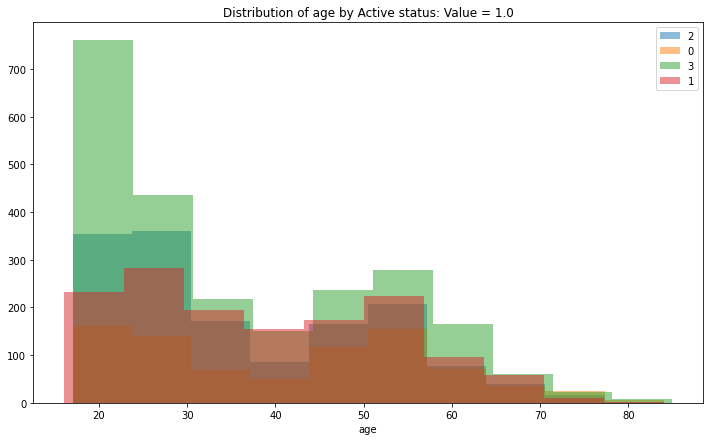

In [152]:
# For Active column
common_col = 'age'
col = 'Active'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['cluster'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['cluster']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

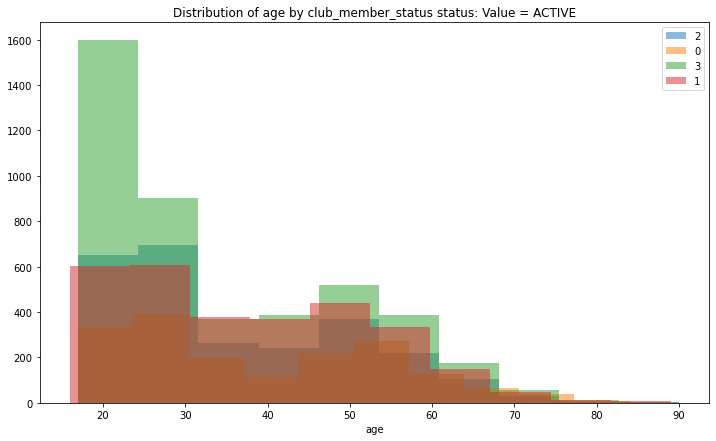

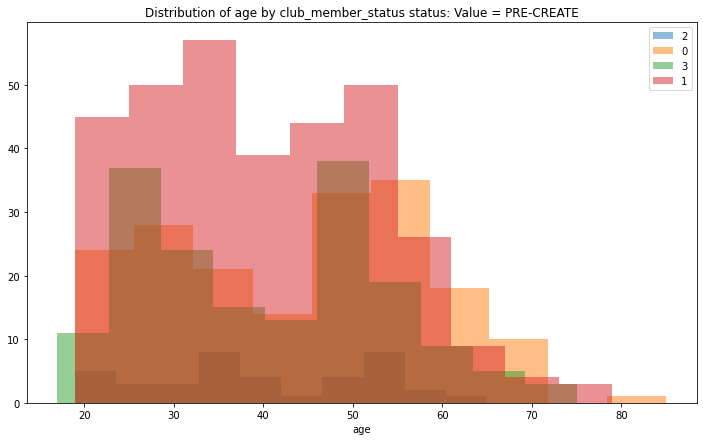

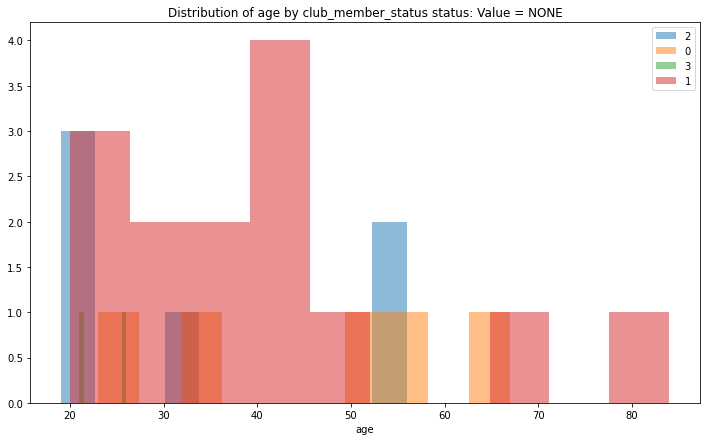

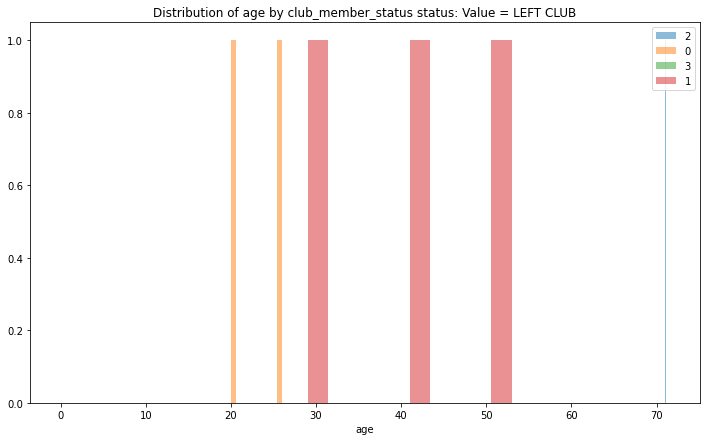

In [153]:
# For club_member_status column
common_col = 'age'
col = 'club_member_status'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['cluster'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['cluster']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

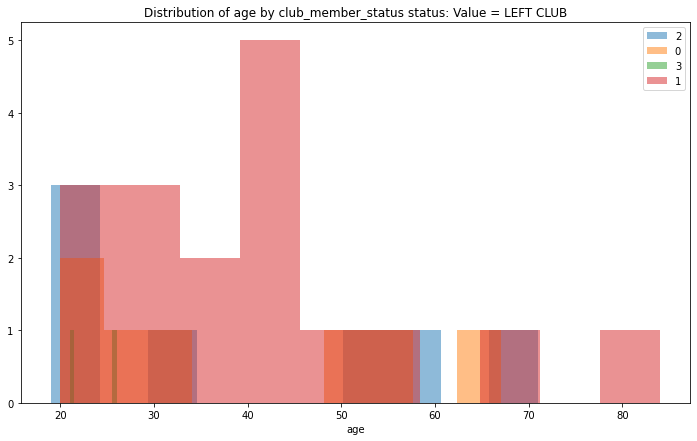

In [154]:
plt.figure(figsize=(12,7))
subset_by_item_df = rfm_customers[rfm_customers['club_member_status'].isin(['LEFT CLUB', 'NONE'])]

for label in rfm_customers['cluster'].unique():
    subset_df = subset_by_item_df[subset_by_item_df['cluster']==label]
    plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
plt.xlabel(f'{common_col}')
plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
plt.show()

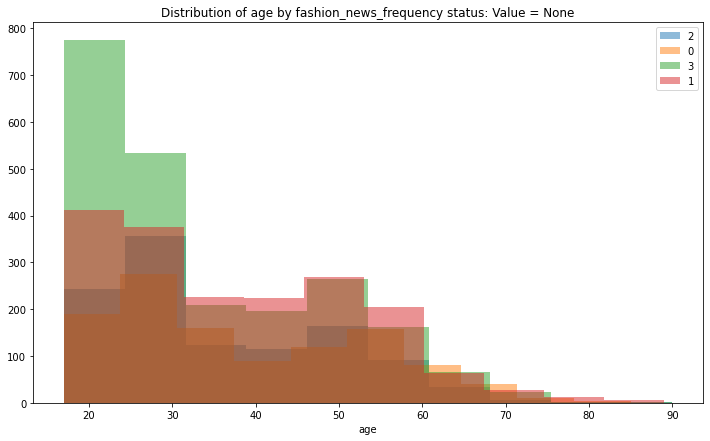

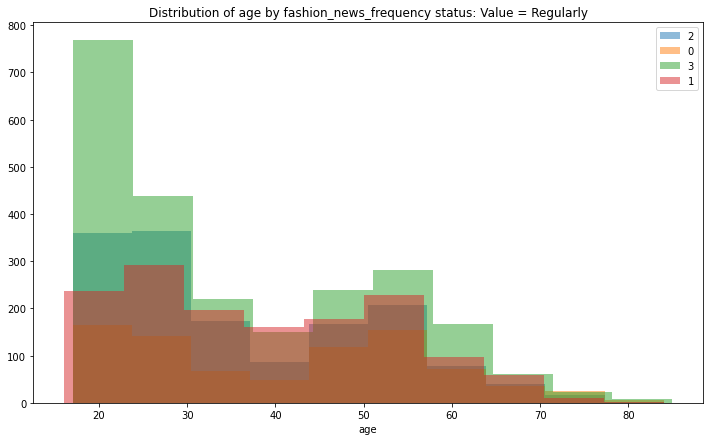

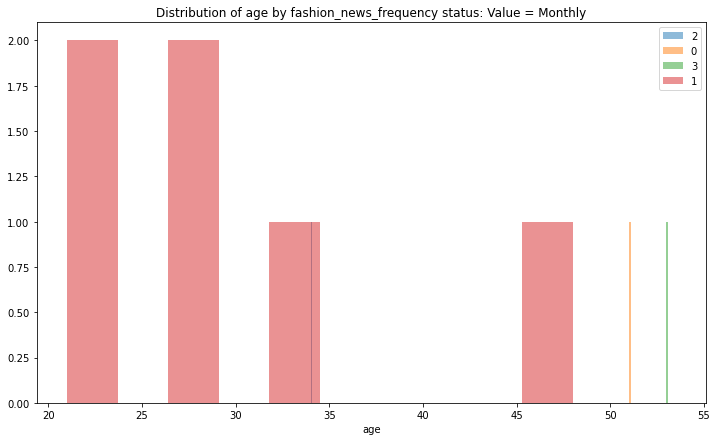

In [155]:
# For fashion_news_frequency column
common_col = 'age'
col = 'fashion_news_frequency'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['cluster'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['cluster']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

#### Active vs Columns

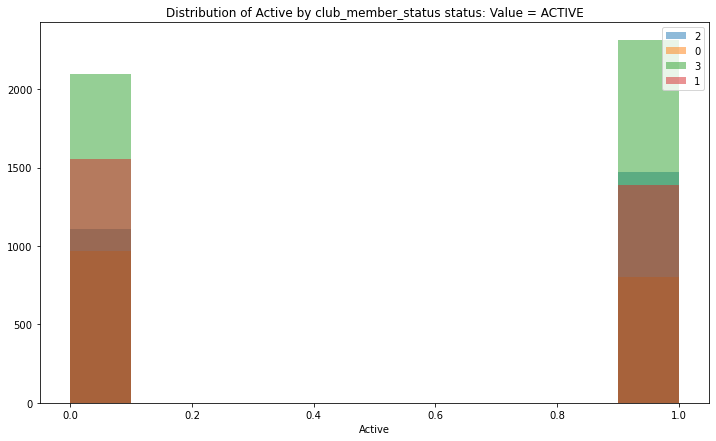

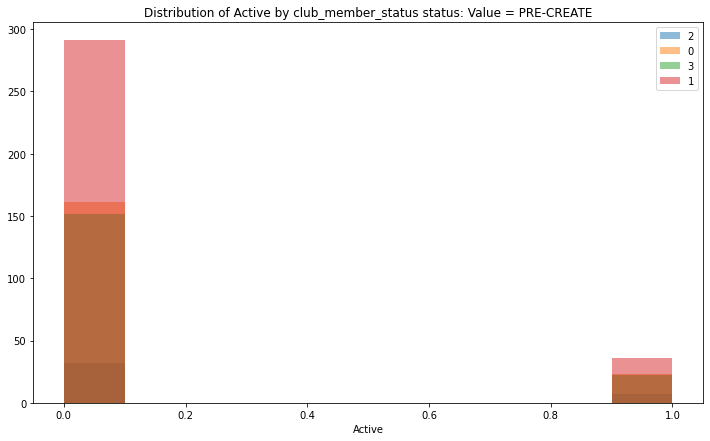

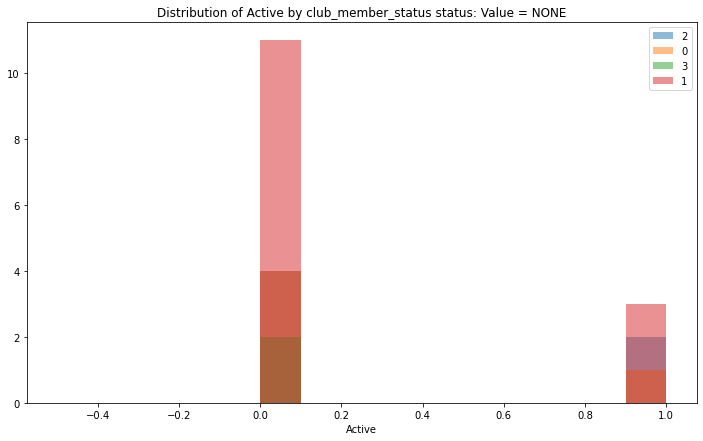

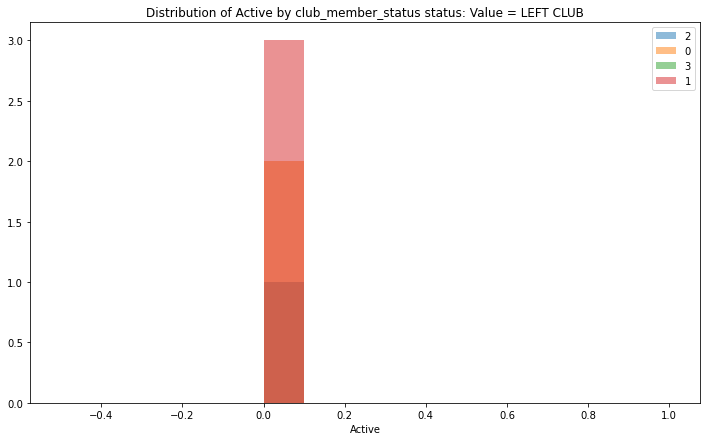

In [156]:
# For age column
common_col = 'Active'
col = 'club_member_status'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['cluster'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['cluster']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

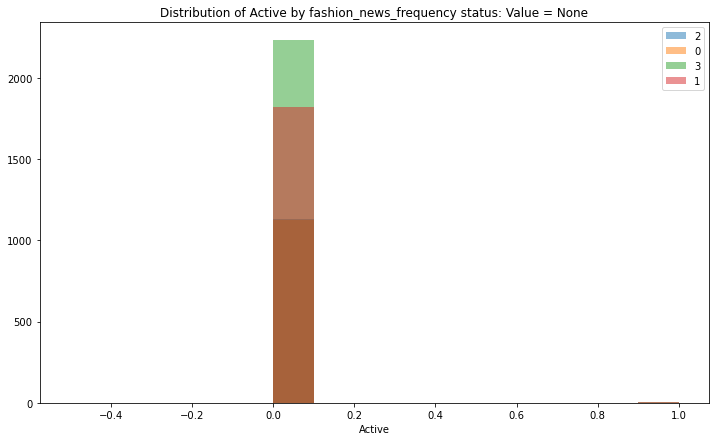

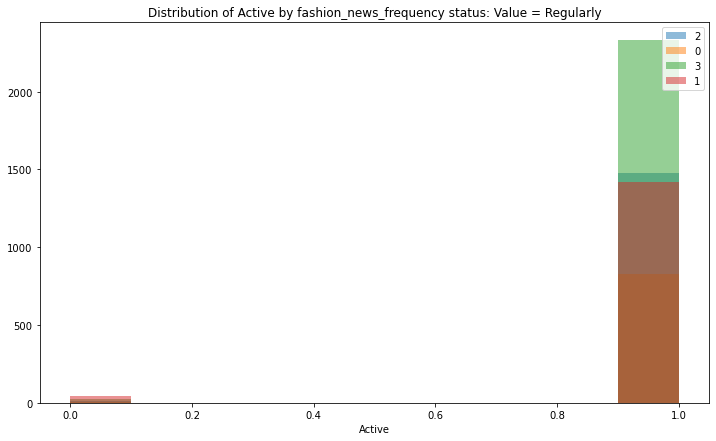

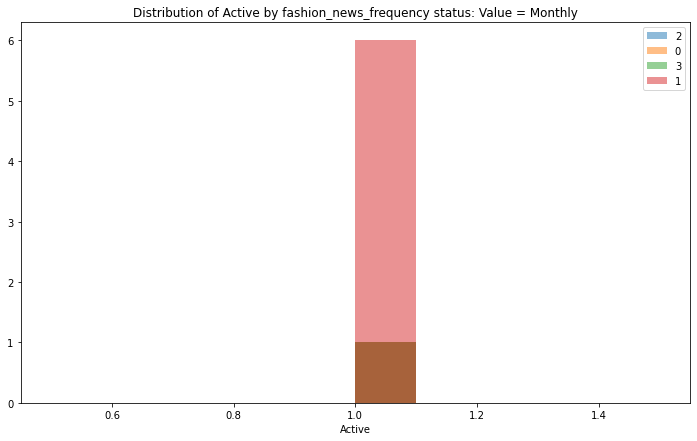

In [157]:
# For age column
common_col = 'Active'
col = 'fashion_news_frequency'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['cluster'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['cluster']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

#### fashion_news_frequency vs club_member_status

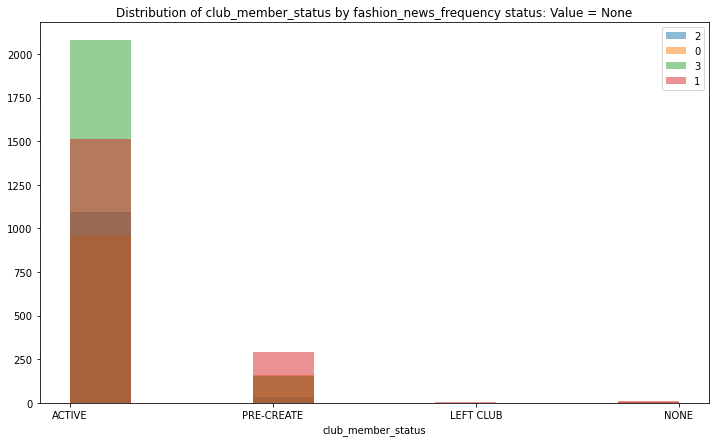

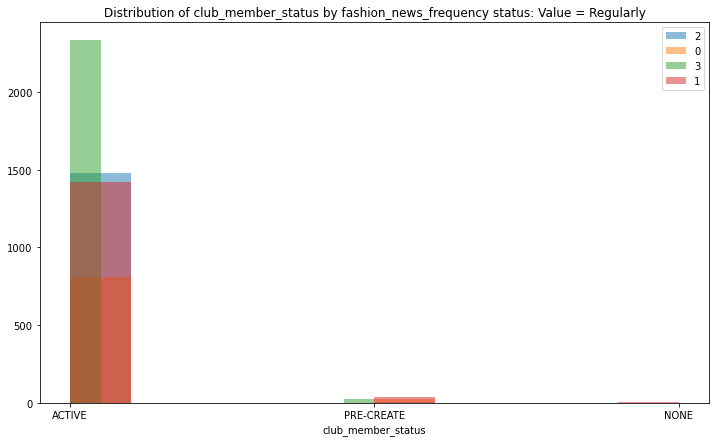

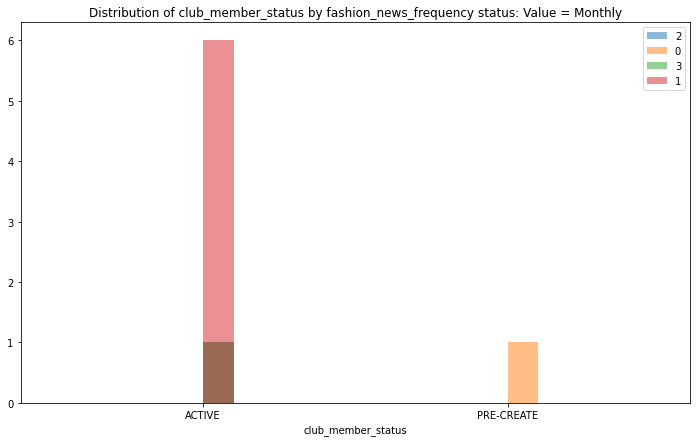

In [158]:
# For age column
common_col = 'club_member_status'
col = 'fashion_news_frequency'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['cluster'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['cluster']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

### 3.3.4 Purchase Behaviour Analysis of RFM Segments (with Transactions Data)

#### Read in CSV and Conduct Basic Analysis

In [159]:
articles = pd.read_csv('/Users/admin/Desktop/Y4S2/BT4211/Project/articles.csv')
print('Dataframe shape:',articles.shape)
articles.head()

Dataframe shape: (105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [160]:
articles = articles.loc[:,['article_id','prod_name','product_type_name','product_group_name',
                          'graphical_appearance_name','colour_group_name','perceived_colour_value_name',
                          'perceived_colour_master_name','department_name','index_name','index_group_name',
                          'section_name','garment_group_name']]
print('Dataframe shape:',articles.shape)
articles.head()

Dataframe shape: (105542, 13)


,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name
0,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
1,108775044,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
2,108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
3,110065001,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"
4,110065002,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"


In [161]:
# Basic data check: Check for null values
for col in articles.columns:
    print("Number of Null Values in", col, " : ", len(articles[articles[col].isna()]), "/", len(articles))

Number of Null Values in article_id  :  0 / 105542
Number of Null Values in prod_name  :  0 / 105542
Number of Null Values in product_type_name  :  0 / 105542
Number of Null Values in product_group_name  :  0 / 105542
Number of Null Values in graphical_appearance_name  :  0 / 105542
Number of Null Values in colour_group_name  :  0 / 105542
Number of Null Values in perceived_colour_value_name  :  0 / 105542
Number of Null Values in perceived_colour_master_name  :  0 / 105542
Number of Null Values in department_name  :  0 / 105542
Number of Null Values in index_name  :  0 / 105542
Number of Null Values in index_group_name  :  0 / 105542
Number of Null Values in section_name  :  0 / 105542
Number of Null Values in garment_group_name  :  0 / 105542


In [162]:
# Convert datatypes to suitable datatypes
articles = articles.astype({'article_id':'str',
                            'prod_name':'category',
                            'product_type_name':'category',
                            'product_group_name':'category',
                            'graphical_appearance_name':'category',
                            'colour_group_name':'category',
                            'perceived_colour_value_name':'category',
                            'perceived_colour_master_name':'category',
                            'department_name':'category',
                            'index_name':'category',
                            'index_group_name':'category',
                            'section_name':'category',
                            'garment_group_name':'category'})
articles.dtypes

article_id                        object
prod_name                       category
product_type_name               category
product_group_name              category
graphical_appearance_name       category
colour_group_name               category
perceived_colour_value_name     category
perceived_colour_master_name    category
department_name                 category
index_name                      category
index_group_name                category
section_name                    category
garment_group_name              category
dtype: object

In [164]:
# Merge Articles with Transaction Data on article_id (Transations data is df_new subsetted at the start)
article_transaction = articles.merge(df_new, on='article_id')

# Merge Article+Transaction with RFM Data on customer_id
rfm_article_transact = article_transaction.merge(rfm_normalised[['customer_id', 'Recency_norm',
                                                                 'Frequency_norm','Monetary_norm','cluster']], on='customer_id')

print('Dataframe shape:',rfm_article_transact.shape)
rfm_article_transact.head()

Dataframe shape: (119358, 21)


,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,customer_id,t_dat,price,sales_channel_id,Recency_norm,Frequency_norm,Monetary_norm,cluster
0,110065001,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear",01fe16e87c866fc2f0054e9ee54e34cf929ff8120e75b0...,2018-11-11,0.025407,1,-0.772619,1.907714,-0.4175,2
1,181448022,Jenny 5-pack,Socks,Socks & Tights,Solid,Black,Dark,Black,UW,Divided,Divided,Divided Basics,"Under-, Nightwear",01fe16e87c866fc2f0054e9ee54e34cf929ff8120e75b0...,2018-10-13,0.007576,1,-0.772619,1.907714,-0.4175,2
2,251510001,Push up 70 den 1p Tights,Underwear Tights,Socks & Tights,Solid,Black,Dark,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,01fe16e87c866fc2f0054e9ee54e34cf929ff8120e75b0...,2018-12-16,0.011288,1,-0.772619,1.907714,-0.4175,2
3,251510001,Push up 70 den 1p Tights,Underwear Tights,Socks & Tights,Solid,Black,Dark,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,01fe16e87c866fc2f0054e9ee54e34cf929ff8120e75b0...,2019-11-29,0.007898,2,-0.772619,1.907714,-0.4175,2
4,251510001,Push up 70 den 1p Tights,Underwear Tights,Socks & Tights,Solid,Black,Dark,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,01fe16e87c866fc2f0054e9ee54e34cf929ff8120e75b0...,2019-11-29,0.007898,2,-0.772619,1.907714,-0.4175,2


#### Remove irrelevant columns and put customer_id to the front of the dataframe

In [166]:
# Drop columns that are not needed
rfm_article_transact = rfm_article_transact.drop(['article_id','t_dat', 'Recency_norm',
                                                  'Frequency_norm','Monetary_norm'], axis=1)

# Place customer_id in the 1st column
customer_id = rfm_article_transact['customer_id']
rfm_article_transact.drop(labels=['customer_id'], axis=1, inplace=True)
rfm_article_transact.insert(0, 'customer_id', customer_id)

rfm_article_transact.head()

,customer_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,price,sales_channel_id,cluster
0,01fe16e87c866fc2f0054e9ee54e34cf929ff8120e75b0...,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear",0.025407,1,2
1,01fe16e87c866fc2f0054e9ee54e34cf929ff8120e75b0...,Jenny 5-pack,Socks,Socks & Tights,Solid,Black,Dark,Black,UW,Divided,Divided,Divided Basics,"Under-, Nightwear",0.007576,1,2
2,01fe16e87c866fc2f0054e9ee54e34cf929ff8120e75b0...,Push up 70 den 1p Tights,Underwear Tights,Socks & Tights,Solid,Black,Dark,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,0.011288,1,2
3,01fe16e87c866fc2f0054e9ee54e34cf929ff8120e75b0...,Push up 70 den 1p Tights,Underwear Tights,Socks & Tights,Solid,Black,Dark,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,0.007898,2,2
4,01fe16e87c866fc2f0054e9ee54e34cf929ff8120e75b0...,Push up 70 den 1p Tights,Underwear Tights,Socks & Tights,Solid,Black,Dark,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,0.007898,2,2


#### Purchase Behaviour Analysis 1: Descriptive analysis

In [167]:
rfm_article_transact.groupby('cluster')['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
               'perceived_colour_value_name','perceived_colour_master_name','department_name',
               'index_name','index_group_name','section_name','garment_group_name','sales_channel_id'].describe()

prod_name                                   product_type_name         \
            count unique                   top freq             count unique   
cluster                                                                        
0            7889   4171   Spanx alot Swimsuit   30              7889     82   
1           16040   6185  Space 5 pkt tregging   44             16040     98   
2           64571  14802             Despacito  127             64571    107   
3           30858   9342             Despacito  103             30858    100   

                       graphical_appearance_name                       \
             top  freq                     count unique    top   freq   
cluster                                                                 
0          Dress  1521                      7889     28  Solid   4074   
1        Sweater  1958                     16040     28  Solid   7470   
2          Dress  7707                     64571     30  Solid  33444   
3          Dress  3049                     30858     28  Solid  16316   

        colour_group_name                      perceived_colour_value_name  \
                    count unique    top   freq                       count   
cluster                                                                      
0                    7889     47  Black   2506                        7889   
1                   16040     49  Black   4487                       16040   
2                   64571     50  Black  19118                       64571   
3                   30858     50  Black   9143                       30858   

                            perceived_colour_master_name                       \
        unique   top   freq                        count unique    top   freq   
cluster                                                                         
0            8  Dark   3854                         7889     18  Black   2485   
1            8  Dark   7573                        16040     18  Black   4437   
2            8  Dark  29312                        64571     19  Black  18961   
3            8  Dark  13578                        30858     19  Black   9092   

        department_name                        index_name                     \
                  count unique       top  freq      count unique         top   
cluster                                                                        
0                  7889    176  Knitwear   682       7889     10  Ladieswear   
1                 16040    212  Swimwear   900      16040     10  Ladieswear   
2                 64571    235  Knitwear  3748      64571     10  Ladieswear   
3                 30858    219  Swimwear  2268      30858     10  Ladieswear   

               index_group_name                           section_name         \
          freq            count unique         top   freq        count unique   
cluster                                                                         
0         4478             7889      5  Ladieswear   5532         7889     51   
1         5155            16040      5  Ladieswear   8269        16040     55   
2        26623            64571      5  Ladieswear  40585        64571     56   
3        11211            30858      5  Ladieswear  19425        30858     52   

                                           garment_group_name         \
                                top   freq              count unique   
cluster                                                                
0        Womens Everyday Collection   1877               7889     21   
1        Womens Everyday Collection   2392              16040     21   
2        Womens Everyday Collection  12670              64571     21   
3        Womens Everyday Collection   5330              30858     21   

                             sales_channel_id                    
                  top   freq            count unique top   freq  
cluster                                               

#### Purchase Behaviour Analysis 2: Analysis of purchase behaviour by segments (Bottom 2 analyses are the same just displayed in different sequences)

#### Purchase Behaviour Analysis 3: Graphical Analysis for the different RFM Segments (Bottom 2 analyses are the same just displayed in different sequences)

In [168]:
def barplot(df, segment, var_col, xticklabels, rotate=False):
    fig, ax = plt.subplots(figsize=(15,7))
    plt.bar(xticklabels, df[var_col])
    for p in ax.patches:
        ax.annotate(p.get_height(), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')

#     ax.set_xticklabels(xticklabels)
    if rotate:
        plt.xticks(rotation=45)

    max_height = max([x.get_height() for x in ax.patches])    
    plt.ylim(0, max_height*1.25)
    plt.title(f'Bar chart of {var_col} for {segment}')
    plt.show()

#### - Purchase Behaviour Analysis 3.1: View graphs by RFM Segments (Compare within RFM Segments) [Based on Top 10 categories]

#### - Purchase Behaviour Analysis 3.2: View graphs by Variables (Compare across RFM Segments)

----- Variable: prod_name -----
RFM Segment: 2


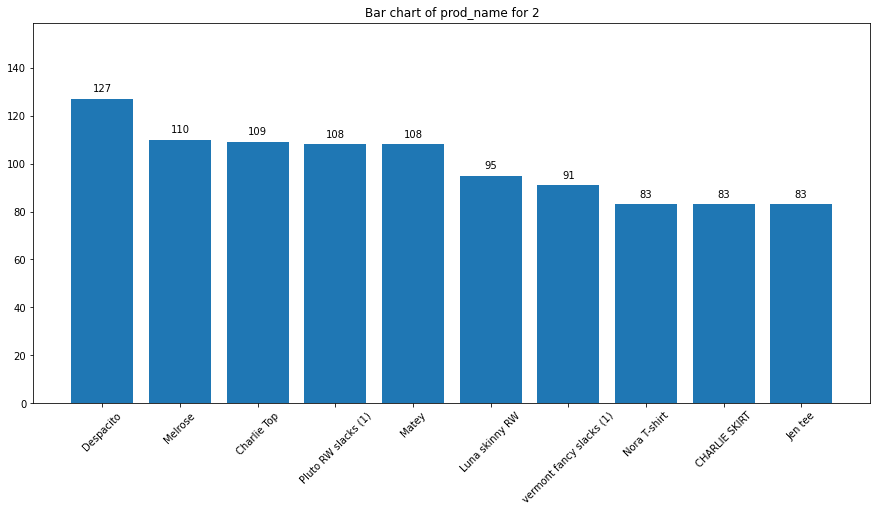



RFM Segment: 3


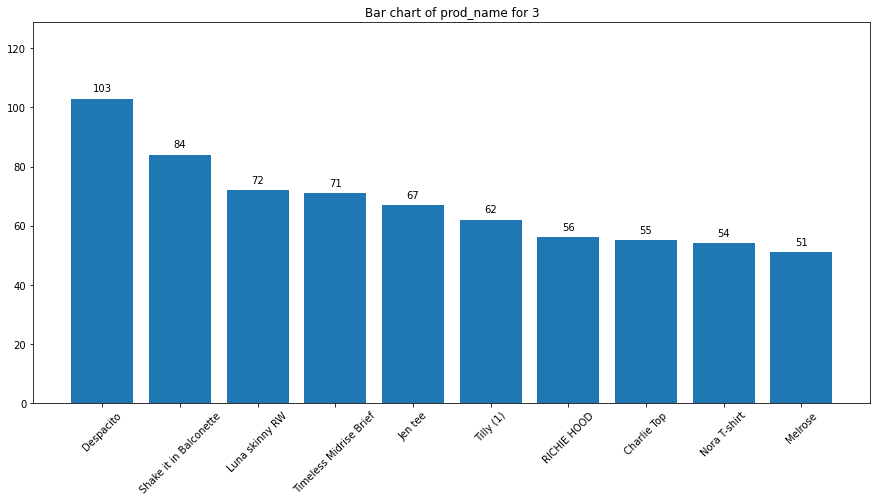



RFM Segment: 1


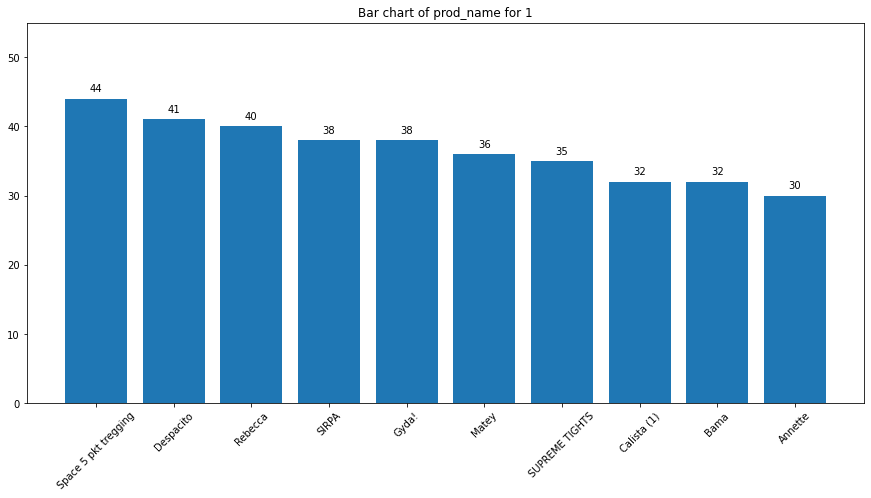



RFM Segment: 0


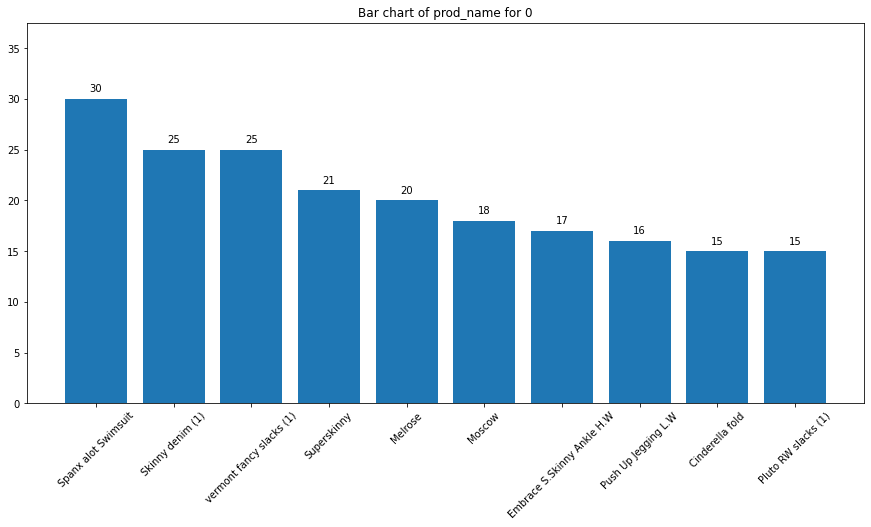



----- Variable: product_type_name -----
RFM Segment: 2


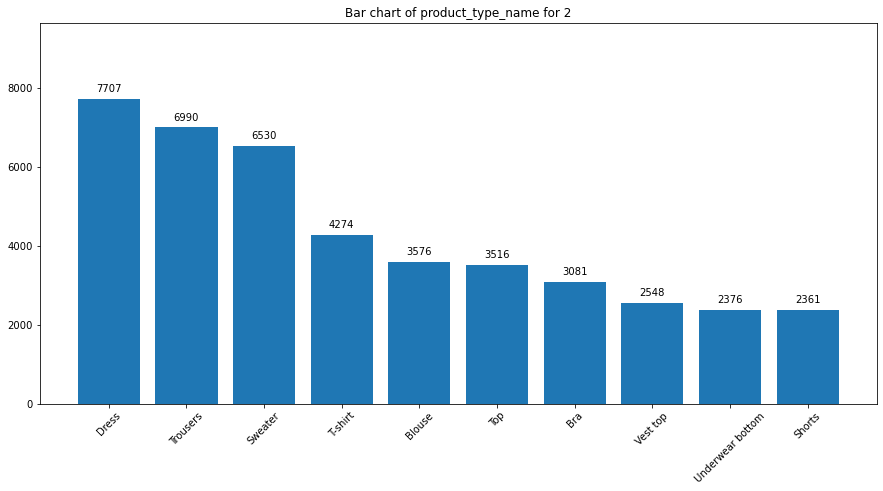



RFM Segment: 3


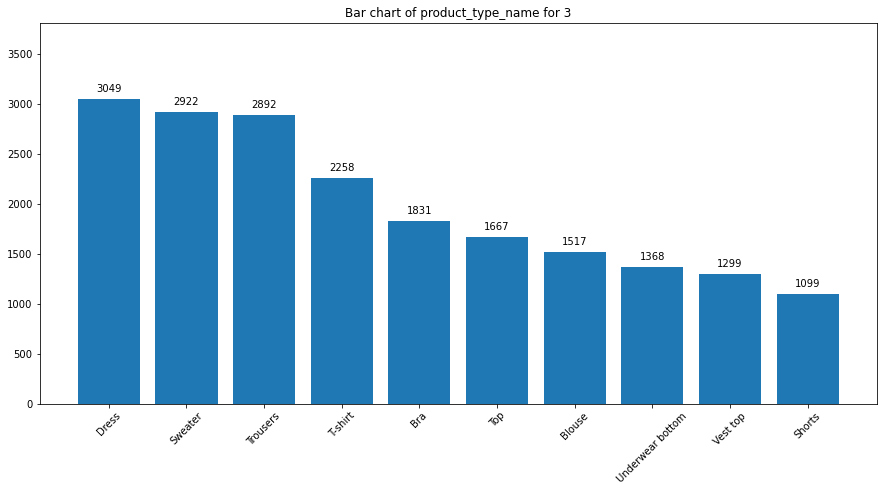



RFM Segment: 1


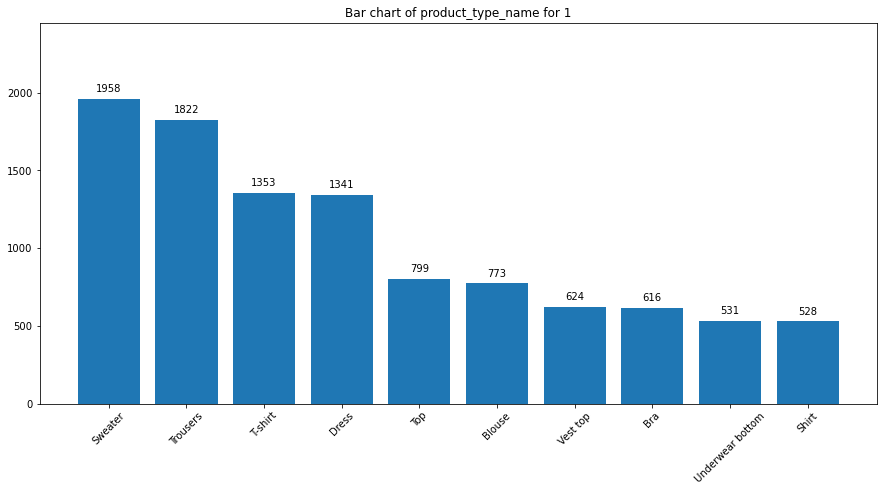



RFM Segment: 0


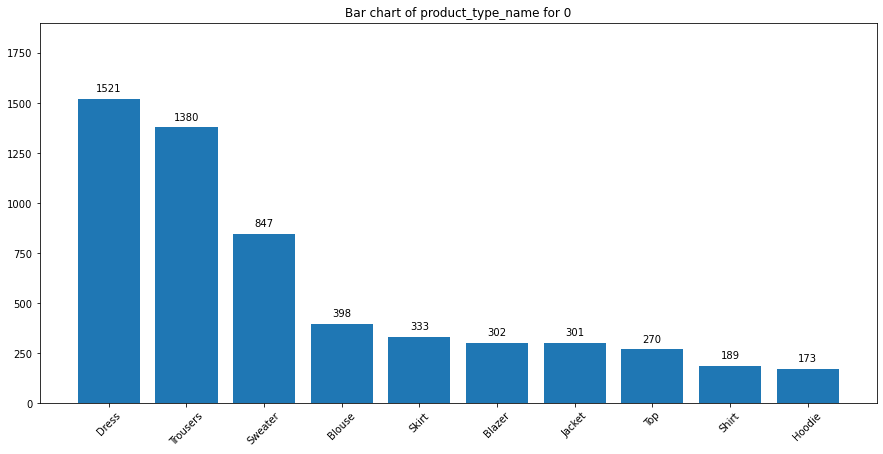



----- Variable: graphical_appearance_name -----
RFM Segment: 2


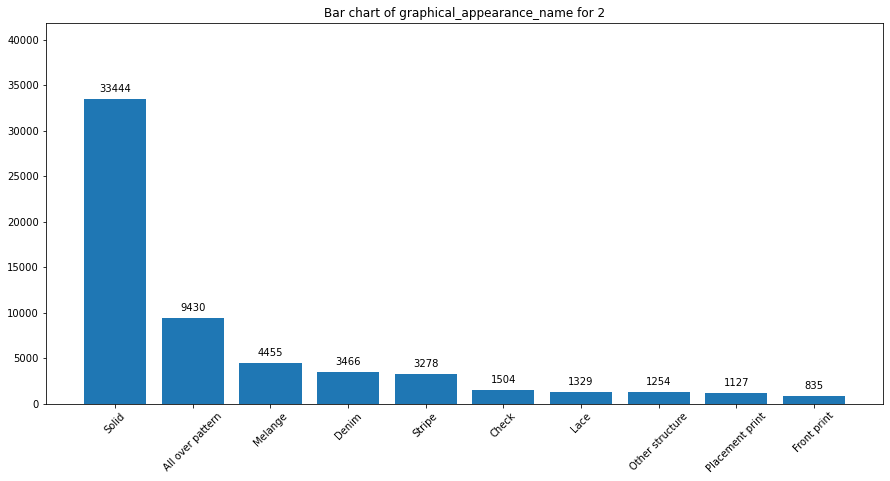



RFM Segment: 3


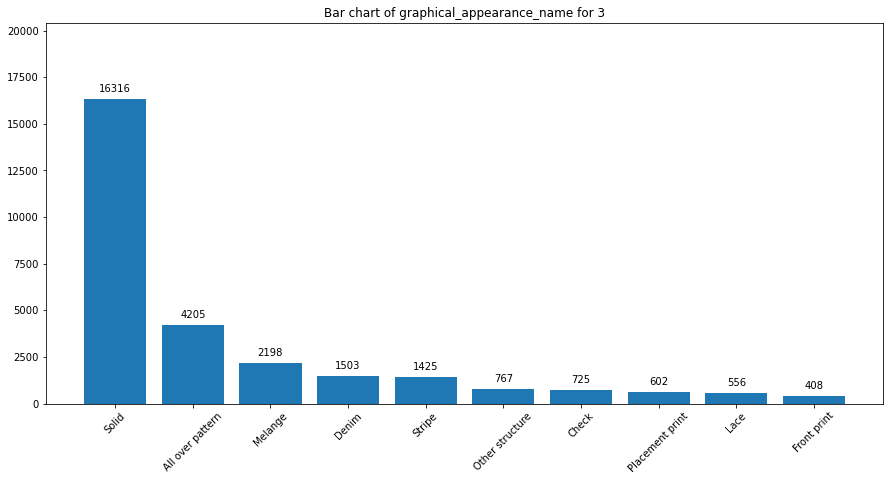



RFM Segment: 1


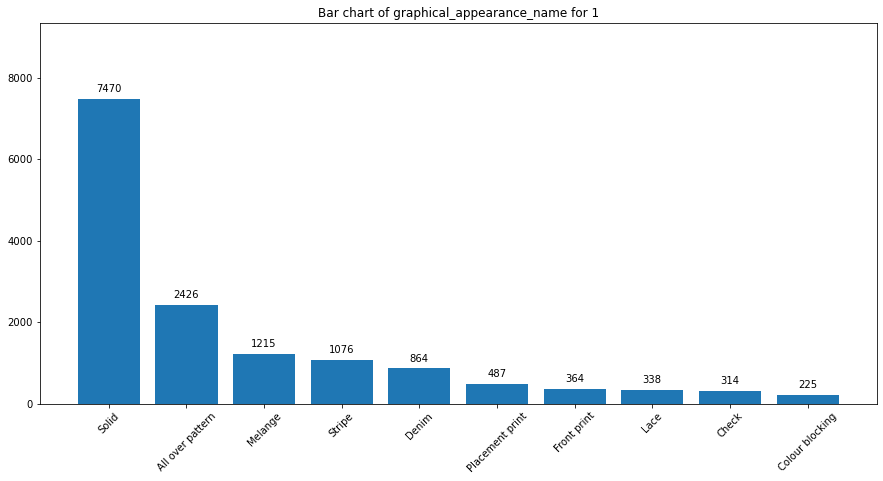



RFM Segment: 0


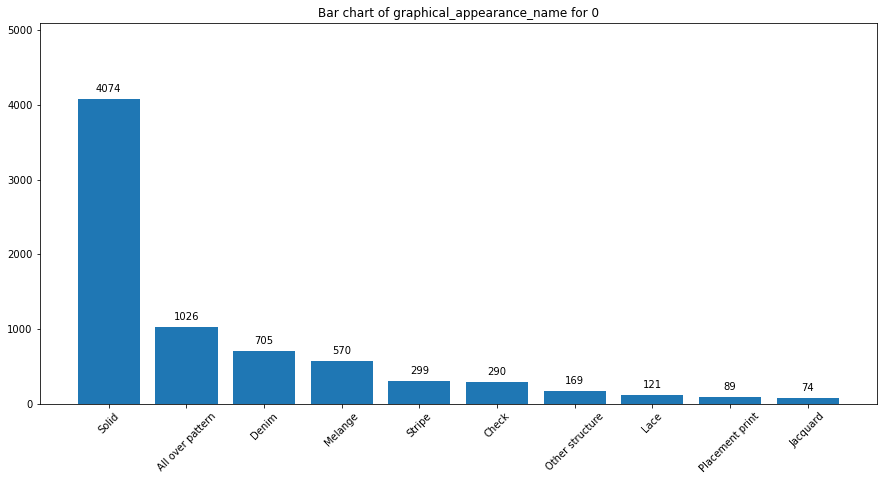



----- Variable: colour_group_name -----
RFM Segment: 2


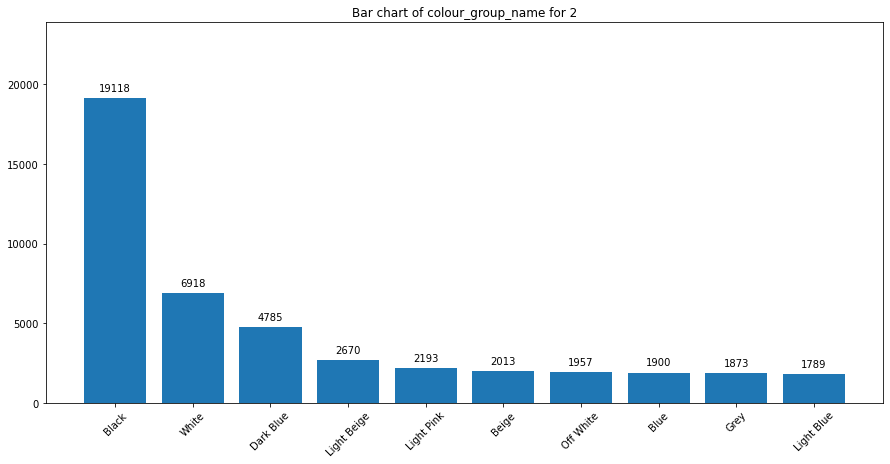



RFM Segment: 3


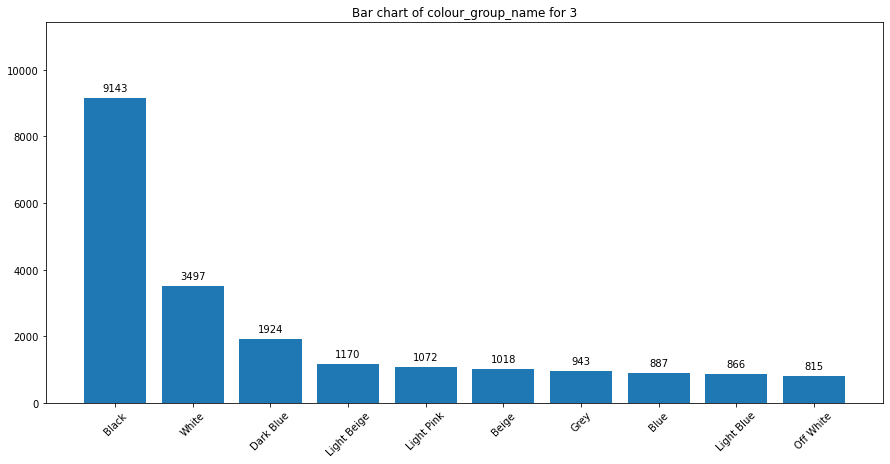



RFM Segment: 1


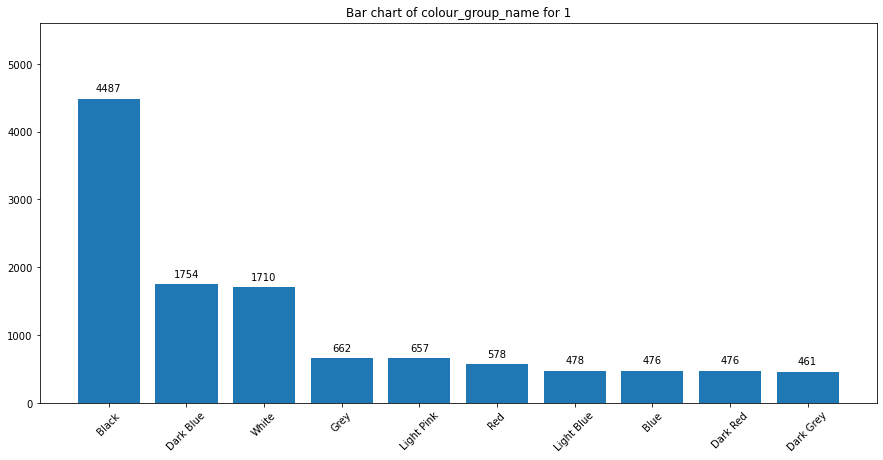



RFM Segment: 0


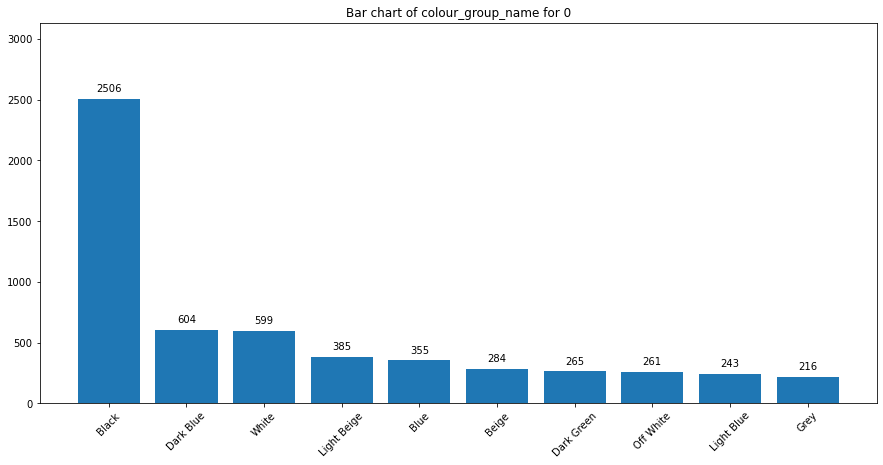



----- Variable: perceived_colour_value_name -----
RFM Segment: 2


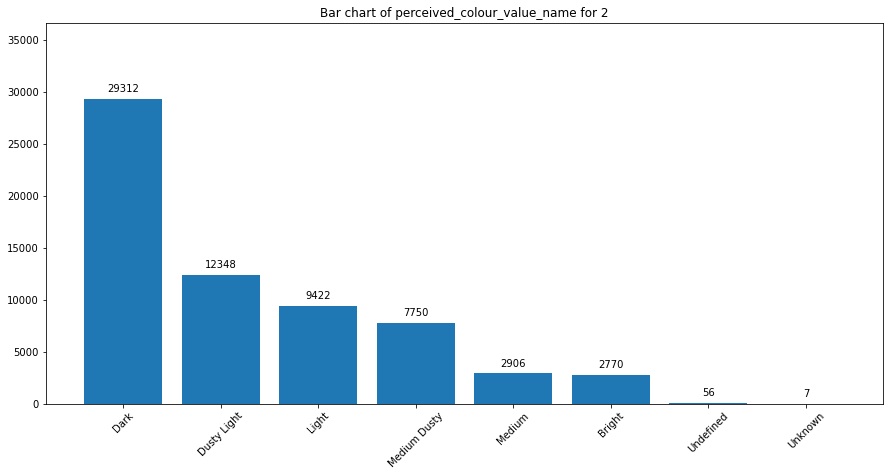



RFM Segment: 3


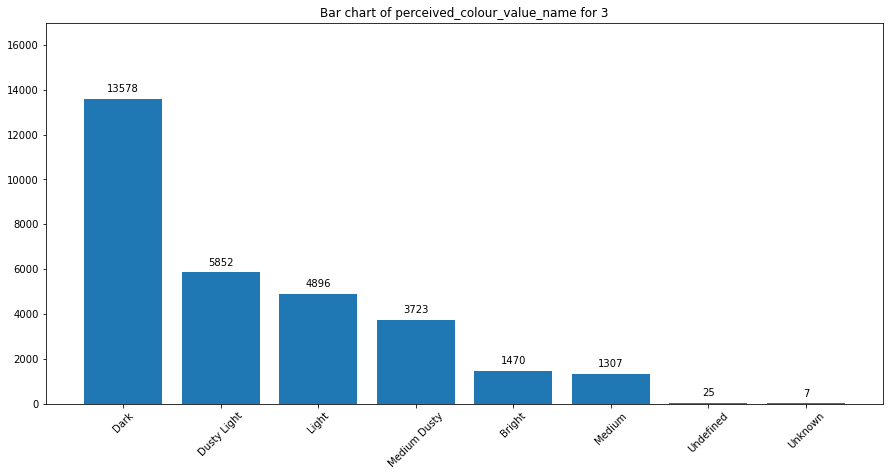



RFM Segment: 1


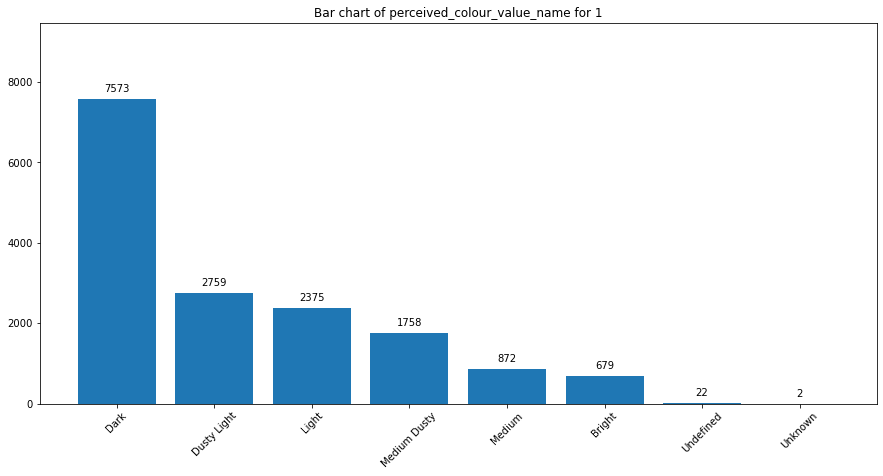



RFM Segment: 0


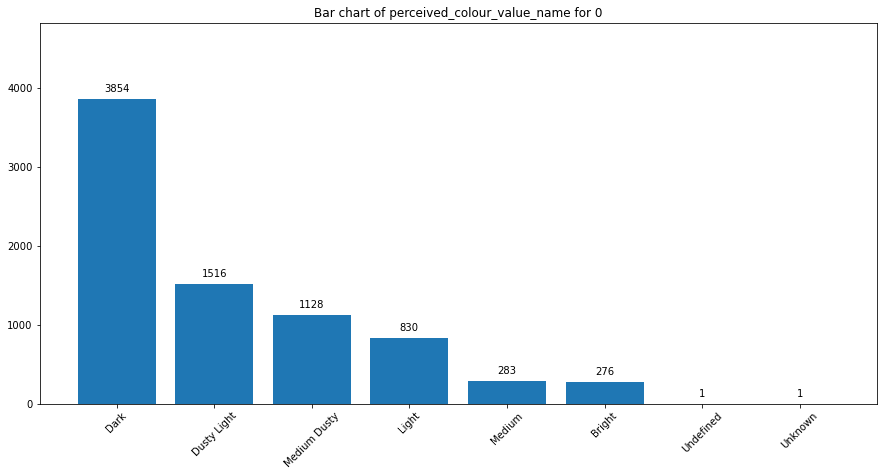



----- Variable: perceived_colour_master_name -----
RFM Segment: 2


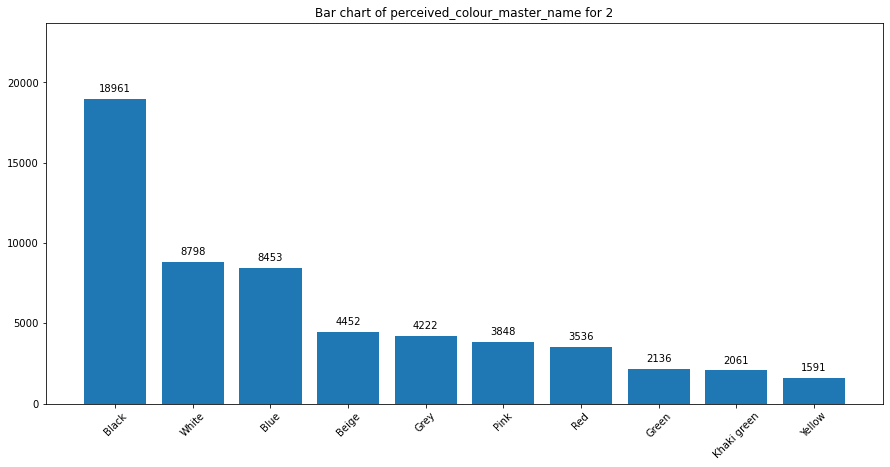



RFM Segment: 3


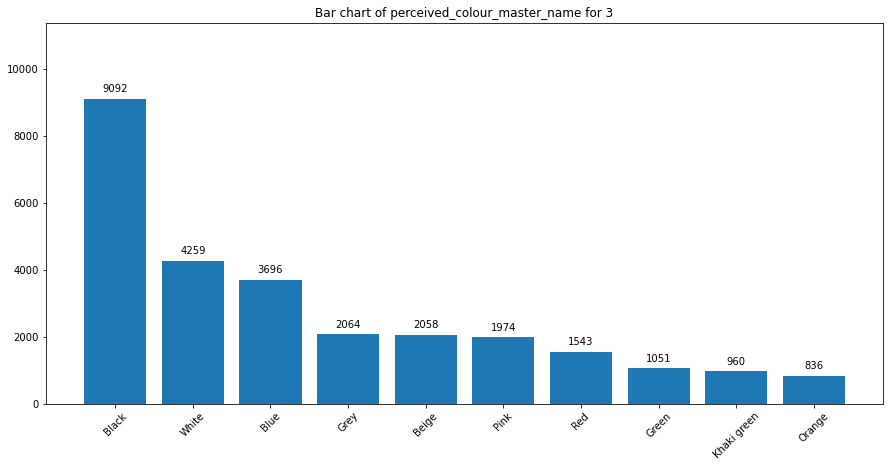



RFM Segment: 1


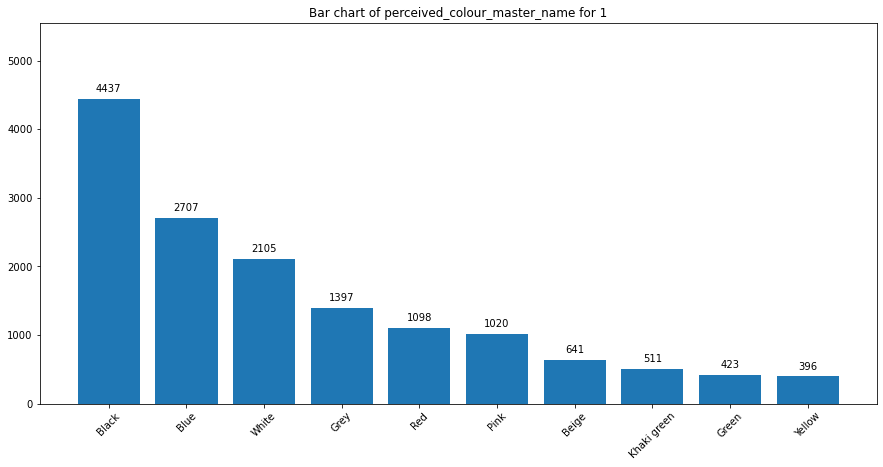



RFM Segment: 0


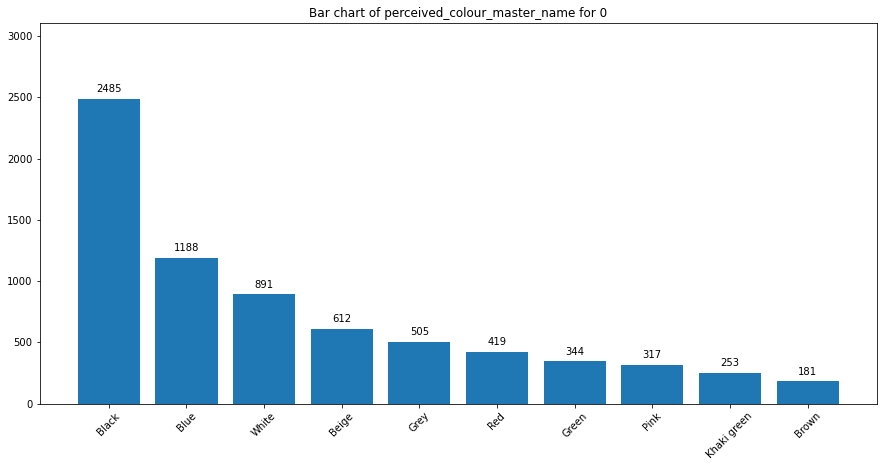



----- Variable: department_name -----
RFM Segment: 2


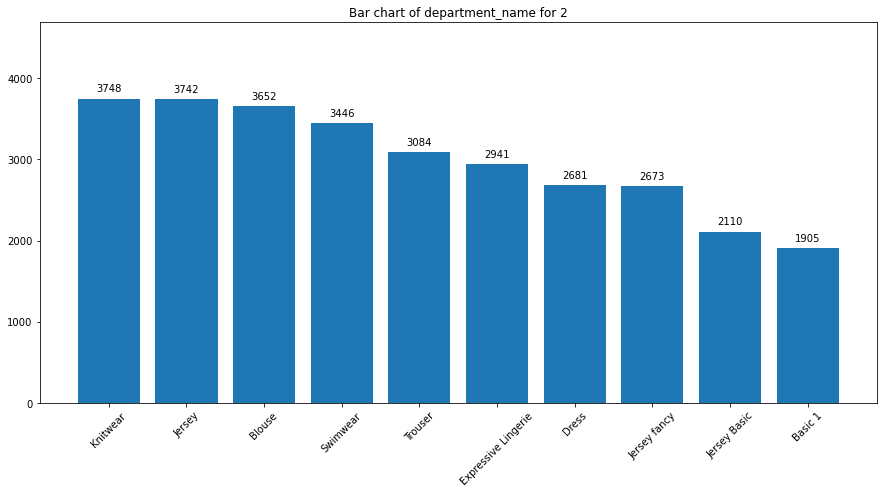



RFM Segment: 3


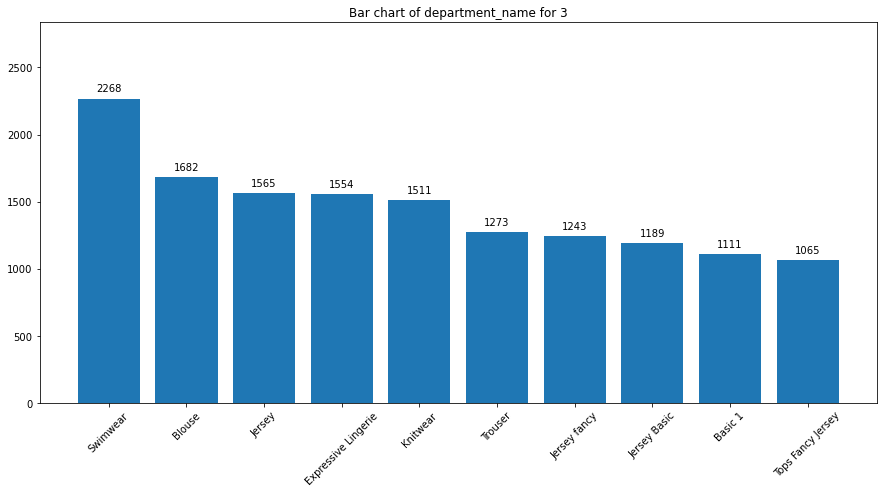



RFM Segment: 1


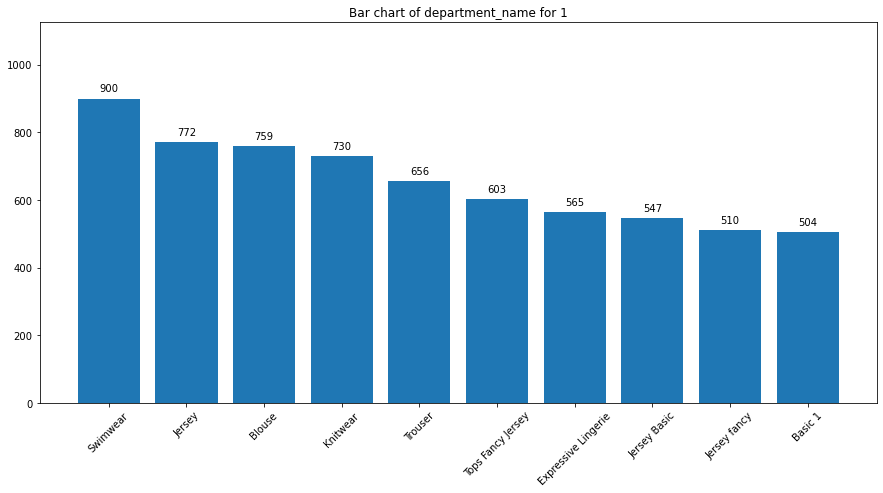



RFM Segment: 0


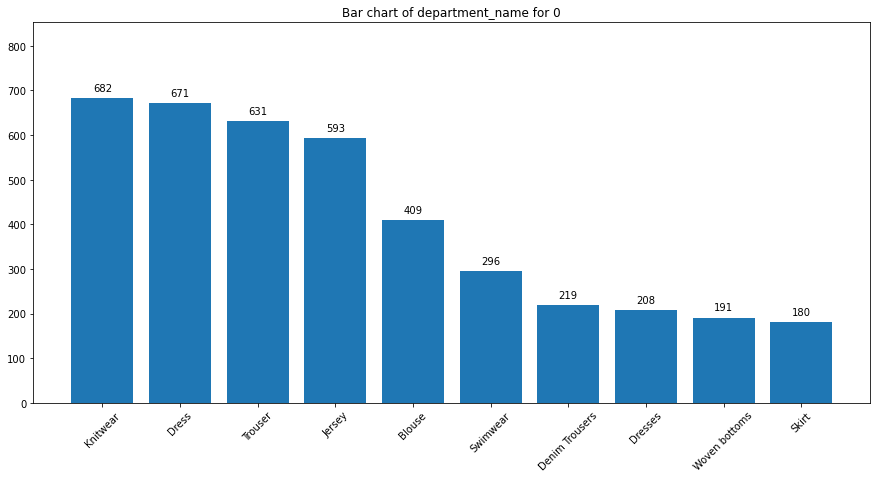



----- Variable: index_name -----
RFM Segment: 2


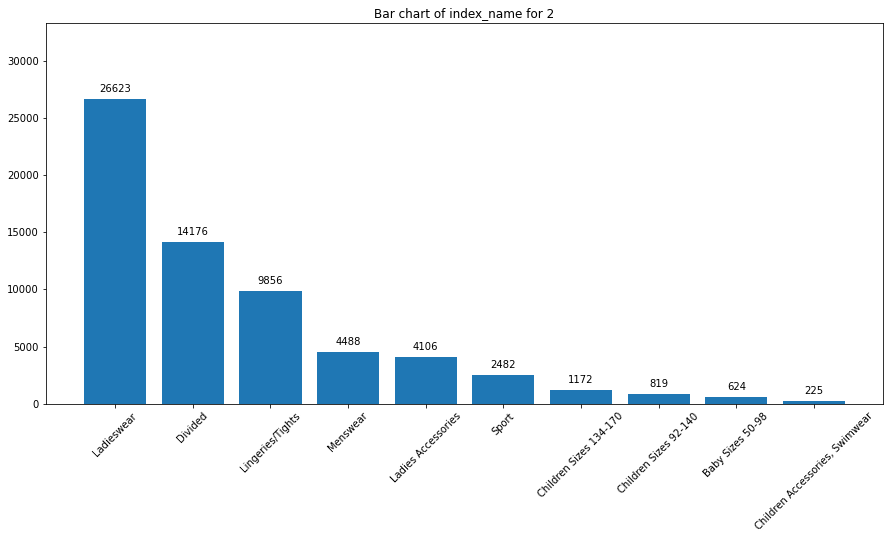



RFM Segment: 3


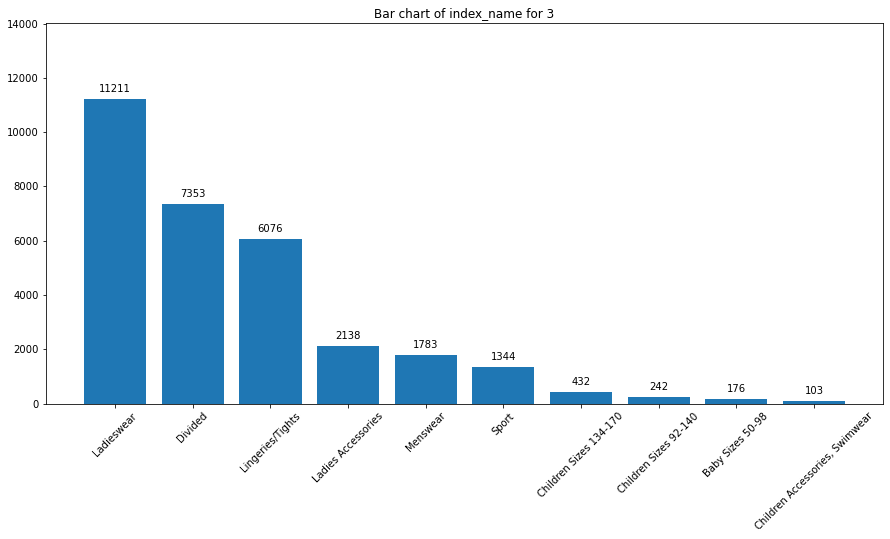



RFM Segment: 1


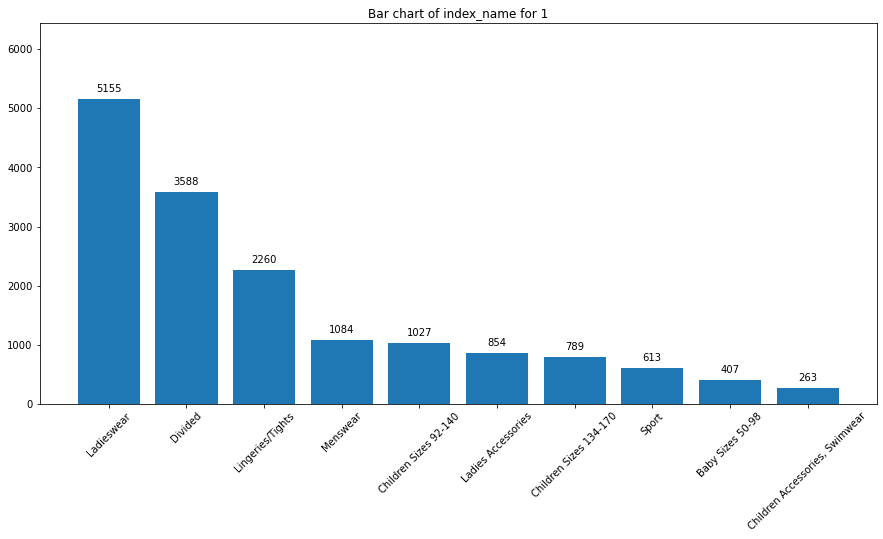



RFM Segment: 0


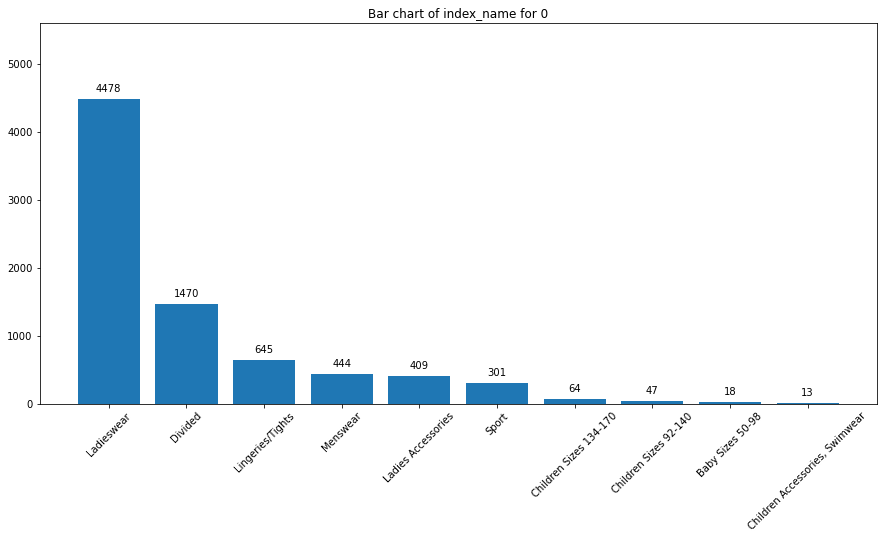



----- Variable: index_group_name -----
RFM Segment: 2


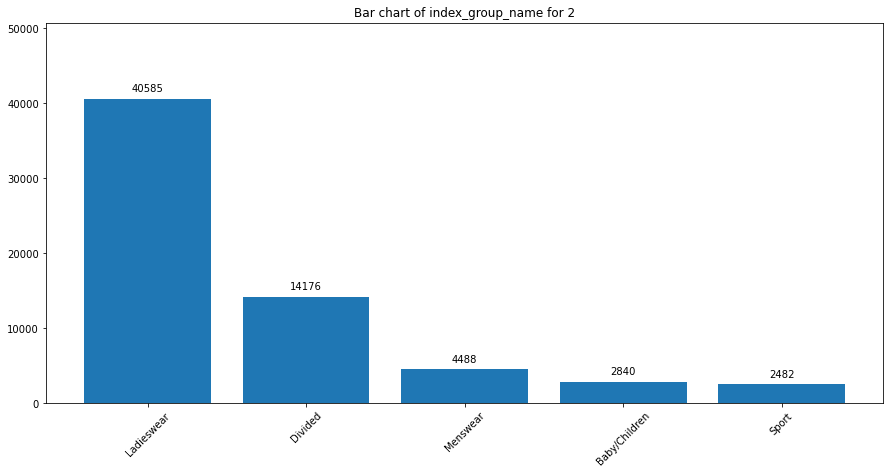



RFM Segment: 3


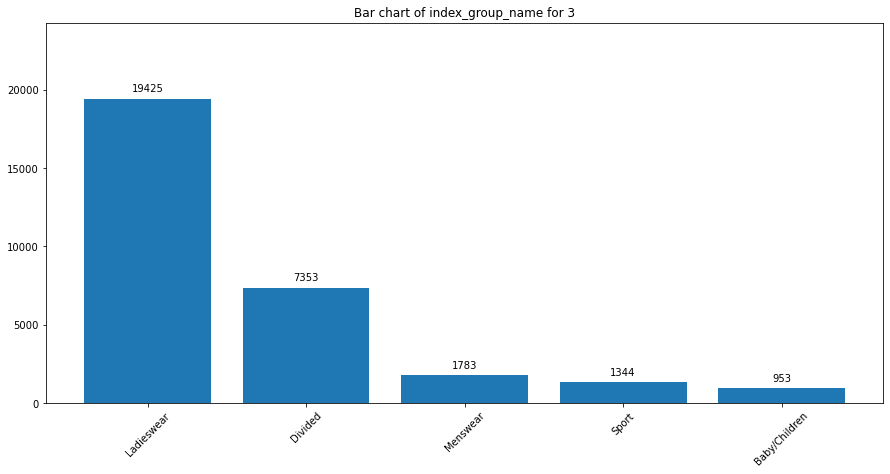



RFM Segment: 1


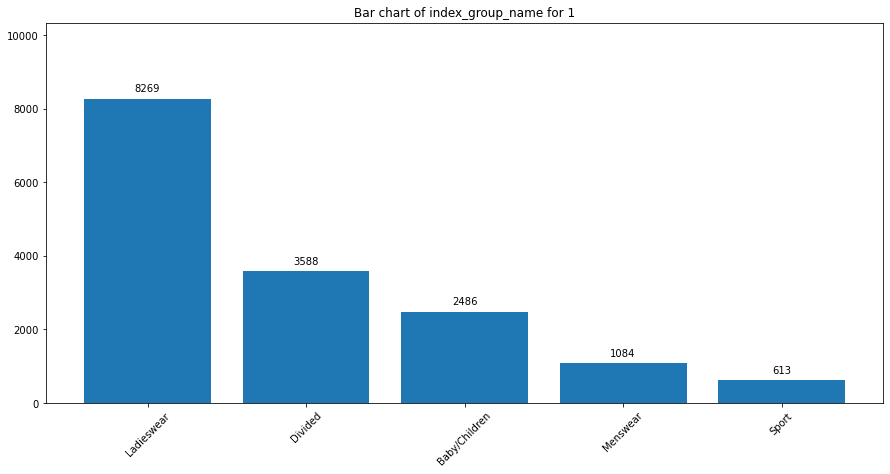



RFM Segment: 0


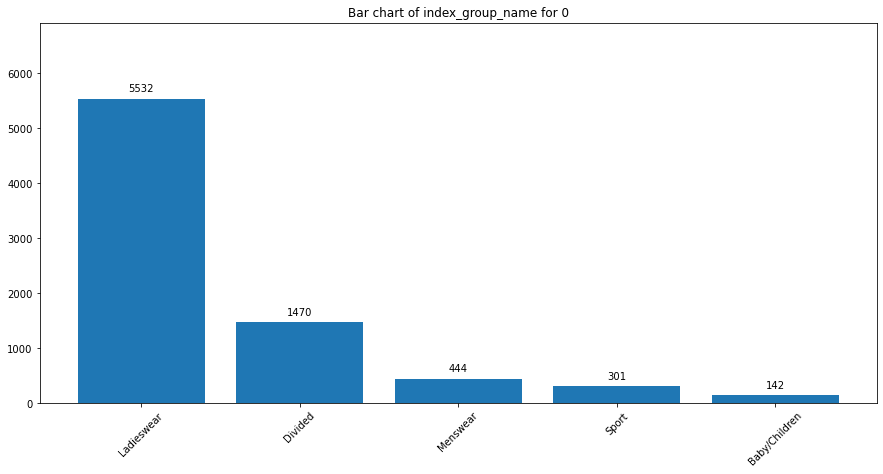



----- Variable: section_name -----
RFM Segment: 2


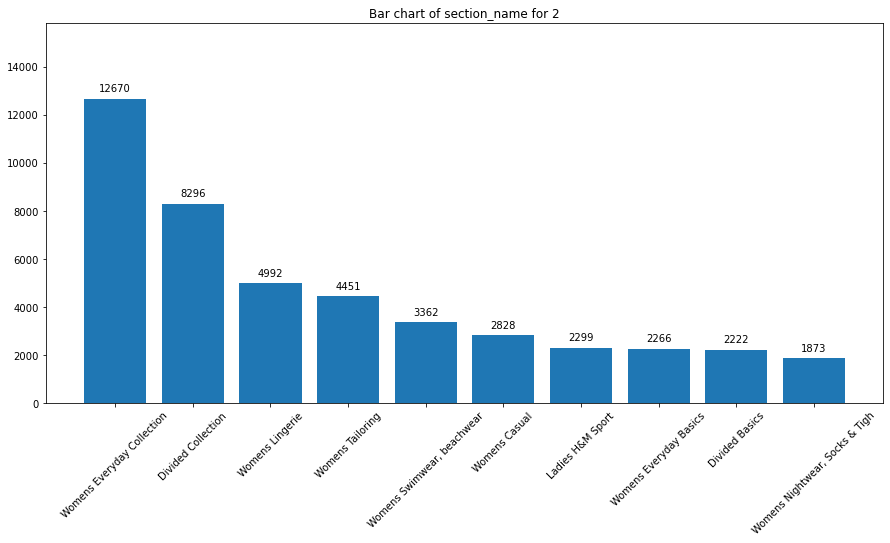



RFM Segment: 3


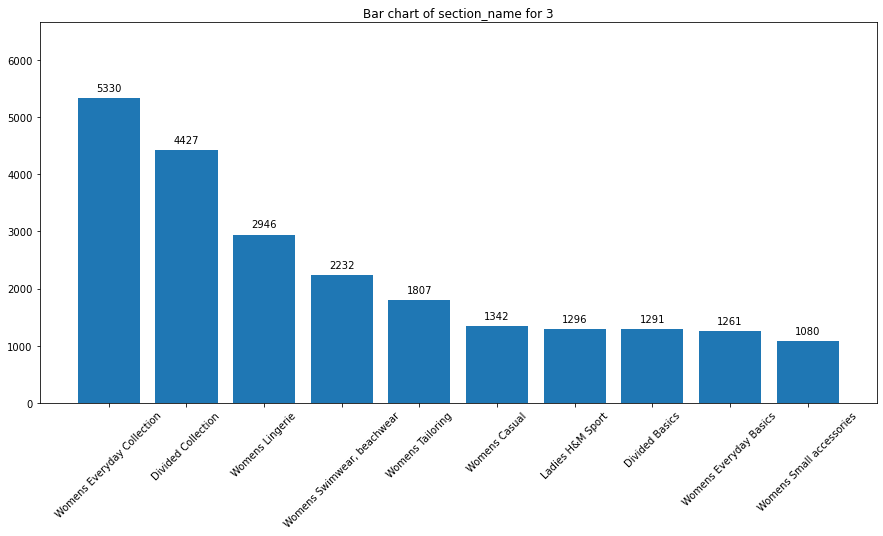



RFM Segment: 1


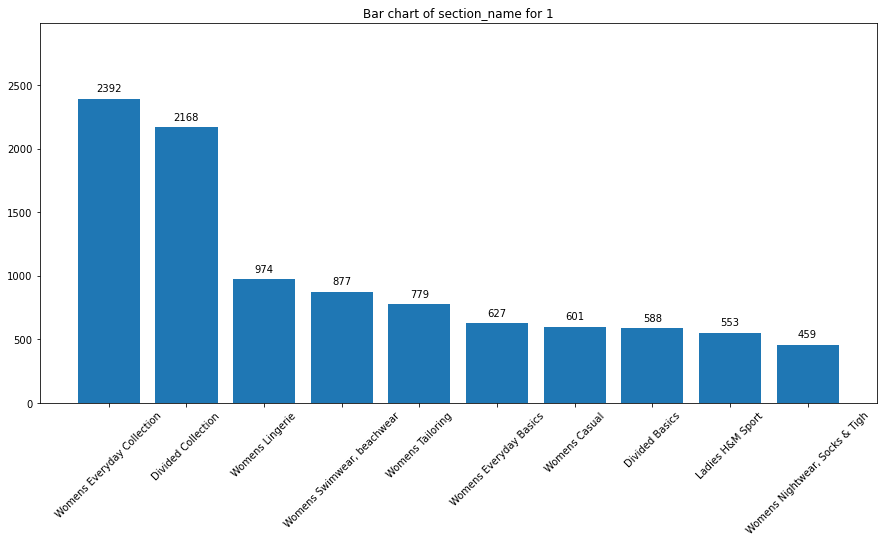



RFM Segment: 0


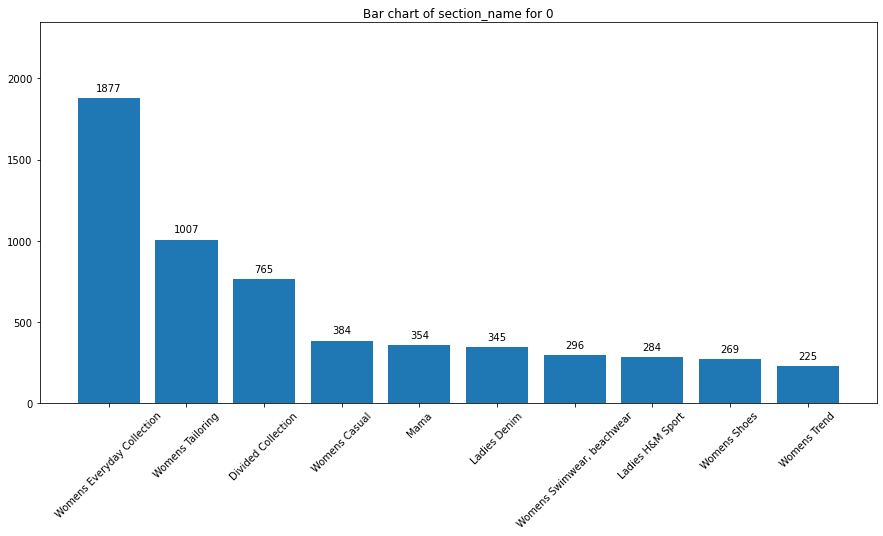



----- Variable: garment_group_name -----
RFM Segment: 2


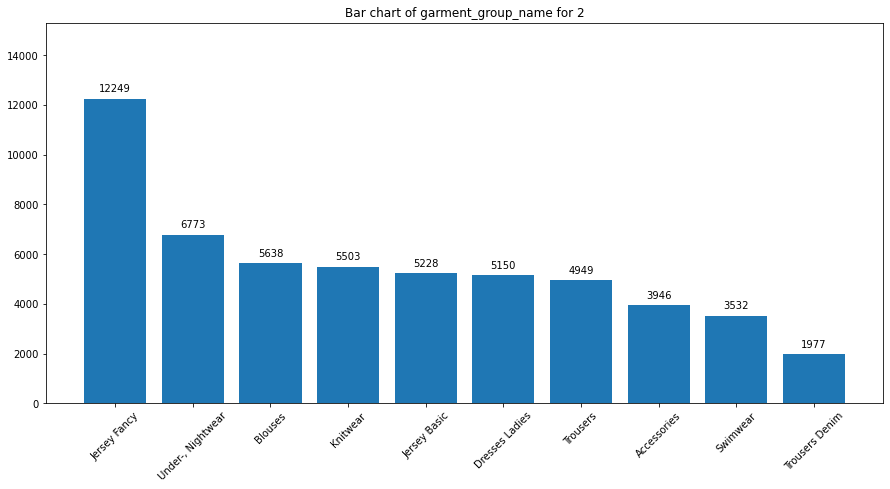



RFM Segment: 3


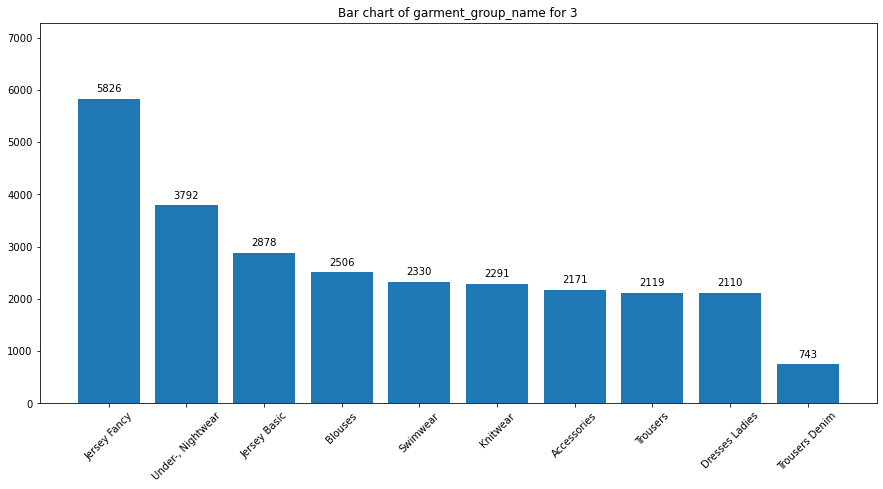



RFM Segment: 1


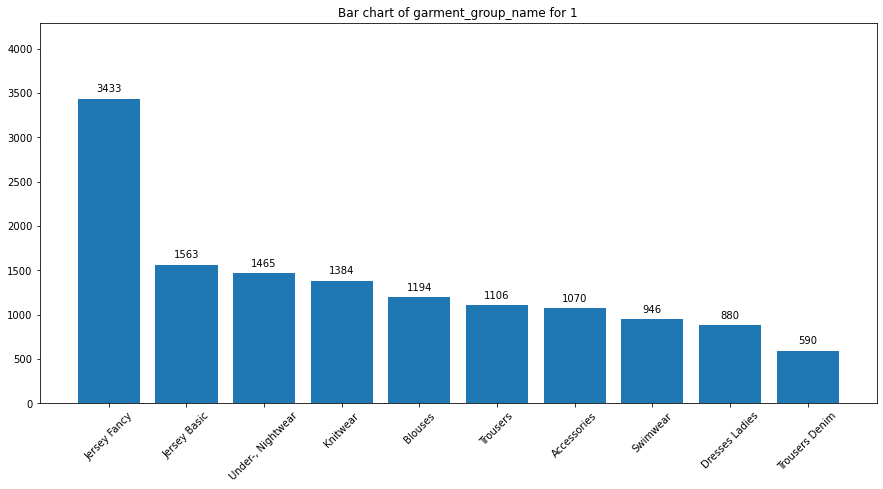



RFM Segment: 0


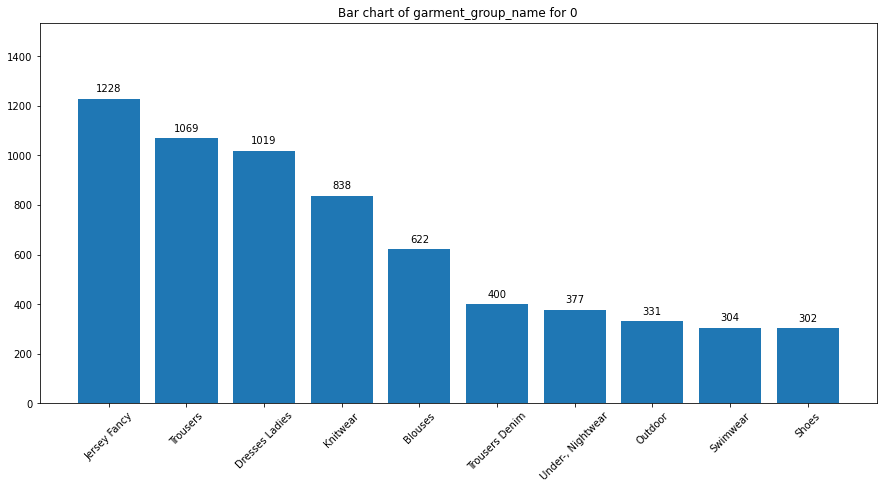



----- Variable: sales_channel_id -----
RFM Segment: 2


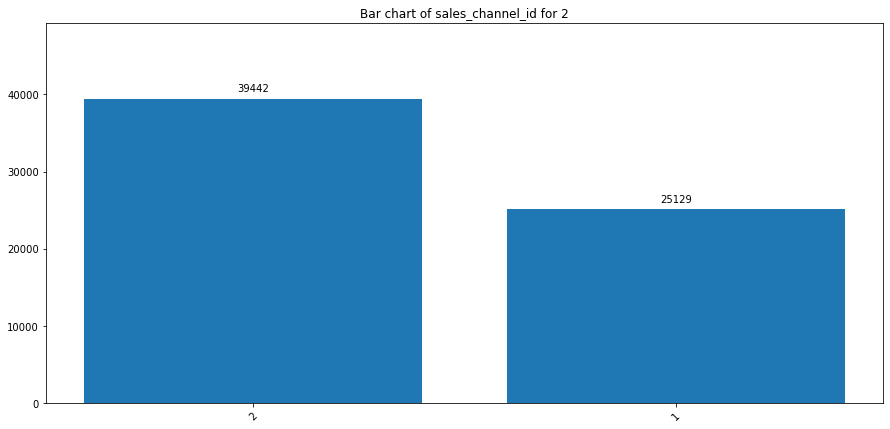



RFM Segment: 3


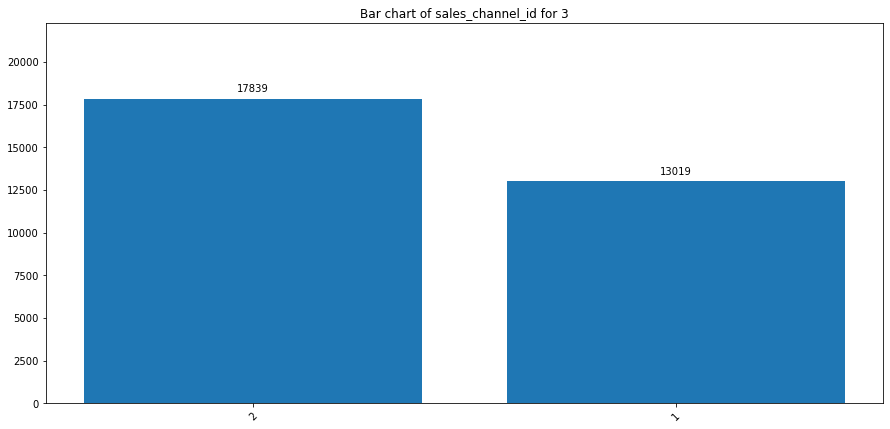



RFM Segment: 1


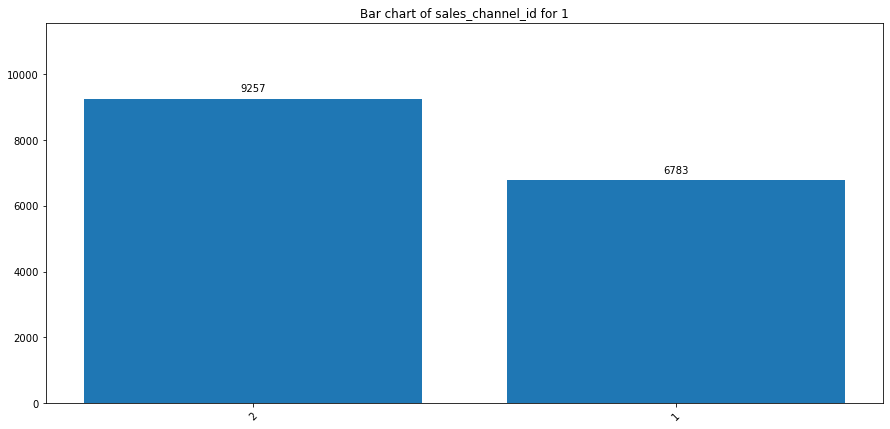



RFM Segment: 0


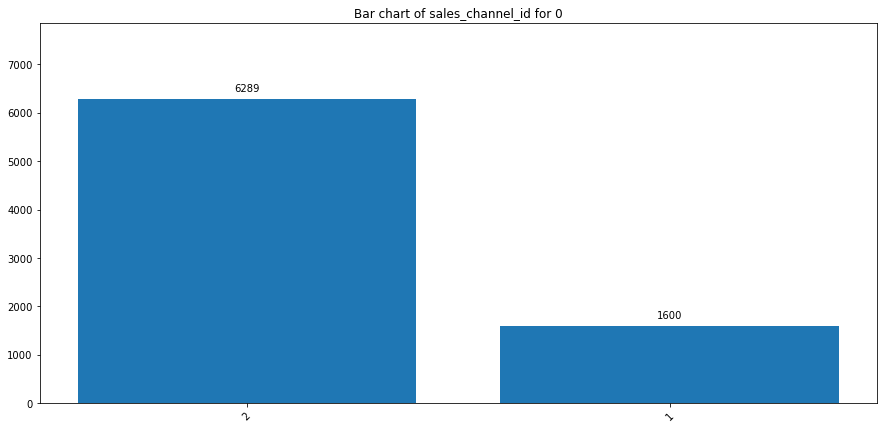

In [169]:
# Based on Top 10 categories in each column variable
labels = list(rfm_article_transact['cluster'].unique())
for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
           'perceived_colour_value_name','perceived_colour_master_name','department_name',
           'index_name','index_group_name','section_name','garment_group_name','sales_channel_id']:
    print('----- Variable:',col,'-----')
    for label in labels:
        print('RFM Segment:',label)
        subset_df = rfm_article_transact[rfm_article_transact['cluster']==label]
        value_counts = subset_df[col].value_counts().loc[lambda x: x>0].to_frame()
        if len(value_counts) > 10:
            value_counts = value_counts[:10]
        barplot(value_counts, label, col, value_counts.index, rotate=True)
        print('\n')

#### Others

In [170]:
rfm_article_transact.head()

,customer_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,price,sales_channel_id,cluster
0,01fe16e87c866fc2f0054e9ee54e34cf929ff8120e75b0...,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear",0.025407,1,2
1,01fe16e87c866fc2f0054e9ee54e34cf929ff8120e75b0...,Jenny 5-pack,Socks,Socks & Tights,Solid,Black,Dark,Black,UW,Divided,Divided,Divided Basics,"Under-, Nightwear",0.007576,1,2
2,01fe16e87c866fc2f0054e9ee54e34cf929ff8120e75b0...,Push up 70 den 1p Tights,Underwear Tights,Socks & Tights,Solid,Black,Dark,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,0.011288,1,2
3,01fe16e87c866fc2f0054e9ee54e34cf929ff8120e75b0...,Push up 70 den 1p Tights,Underwear Tights,Socks & Tights,Solid,Black,Dark,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,0.007898,2,2
4,01fe16e87c866fc2f0054e9ee54e34cf929ff8120e75b0...,Push up 70 den 1p Tights,Underwear Tights,Socks & Tights,Solid,Black,Dark,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,0.007898,2,2


In [171]:
price_rfm = rfm_article_transact.loc[:,['price','cluster']]
price_rfm.head()

,price,cluster
0,0.025407,2
1,0.007576,2
2,0.011288,2
3,0.007898,2
4,0.007898,2


In [172]:
price_rfm['price'] *= 1000
price_rfm.head()

,price,cluster
0,25.406780,2
1,7.576271,2
2,11.288136,2
3,7.898305,2
4,7.898305,2


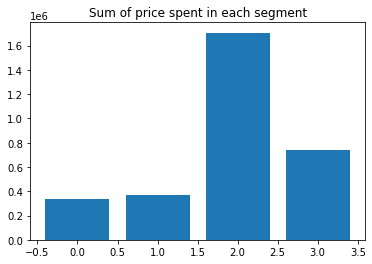

,cluster,price
0,0,3.354619e+05
1,1,3.670950e+05
2,2,1.706202e+06
3,3,7.416781e+05


In [173]:
price_sum = pd.DataFrame(price_rfm.groupby('cluster')['price'].sum()).reset_index()
plt.bar(price_sum['cluster'],price_sum['price'])
plt.title('Sum of price spent in each segment')
plt.show()

price_sum

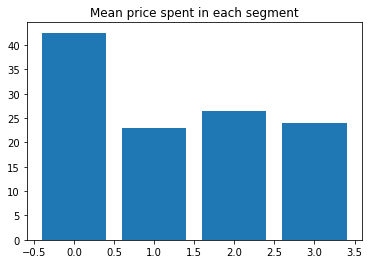

,cluster,price
0,0,42.522738
1,1,22.886220
2,2,26.423661
3,3,24.035198


In [174]:
price_mean = pd.DataFrame(price_rfm.groupby('cluster')['price'].mean()).reset_index()
plt.bar(price_mean['cluster'],price_mean['price'])
plt.title('Mean price spent in each segment')
plt.show()

price_mean

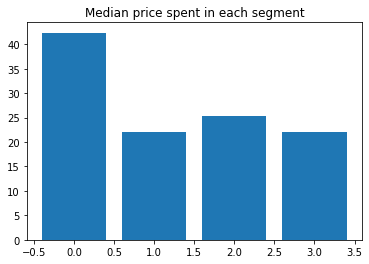

,cluster,price
0,0,42.355932
1,1,22.016949
2,2,25.406780
3,3,22.016949


In [175]:
price_median = pd.DataFrame(price_rfm.groupby('cluster')['price'].median()).reset_index()
plt.bar(price_median['cluster'],price_median['price'])
plt.title('Median price spent in each segment')
plt.show()

price_median

In [176]:
age_rfm = rfm_customers.loc[:,['age','cluster']]
age_rfm.head()

,age,cluster
0,49,2
1,24,0
2,52,3
3,29,3
4,31,1


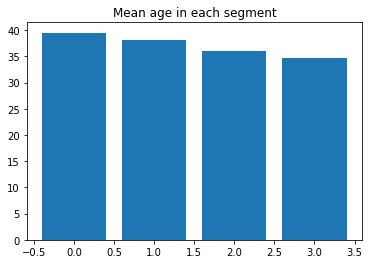

,cluster,age
0,0,39.534967
1,1,38.060883
2,2,35.990473
3,3,34.646751


In [177]:
age_mean = pd.DataFrame(age_rfm.groupby('cluster')['age'].mean()).reset_index()
plt.bar(age_mean['cluster'],age_mean['age'])
plt.title('Mean age in each segment')
plt.show()

age_mean

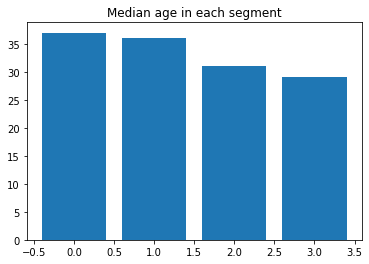

,cluster,age
0,0,37
1,1,36
2,2,31
3,3,29


In [178]:
age_median = pd.DataFrame(age_rfm.groupby('cluster')['age'].median()).reset_index()
plt.bar(age_median['cluster'],age_median['age'])
plt.title('Median age in each segment')
plt.show()

age_median